In [1]:
#.............................................
# IMPORT STATEMENTS
#.............................................

# local env is py310

#Handling data
import numpy as np
import netCDF4 as nc
#Plotting figures
import matplotlib.pyplot as plt #Main plotting package
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker

#machine learning package
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow import keras
from keras import layers
from tensorflow.keras import layers, Model

import numpy as np

from tensorflow.keras import layers, Sequential, Input, Model


from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape, TimeDistributed, LSTM, ConvLSTM2D, Cropping2D
from tensorflow.keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

from netCDF4 import Dataset
import os


2.14.0
Num GPUs Available:  0


In [2]:

# Function to process each NetCDF file
def process_file(file_path):
    # Open the NetCDF file
    nc_file = Dataset(file_path, mode='r')

    # Extract the variable (e.g., 'pr') and its data
    precip_data = nc_file.variables['pr'][:] * 3600

    #normalized_data = smooth_normalize(precip_data)
    #standardized_data = standardize(precip_data)



    # Close the NetCDF file
    nc_file.close()

    return precip_data

# Path to the directory containing NetCDF files
directory_path = 'C:/Users/hebam/OneDrive - University of Calgary/Mitacs/data/Orig_all/'

# List to store the reshaped data
all_reshaped_data = []

# Loop through each file in the directory
for file_name in os.listdir(directory_path):
    if file_name.endswith('.nc'):  # Check for .nc files
        file_path = os.path.join(directory_path, file_name)  # Create full file path
        reshaped_data = process_file(file_path)
        all_reshaped_data.append(reshaped_data)

# Convert the list to a NumPy array for easier manipulation if needed
all_reshaped_data = np.array(all_reshaped_data)

# Check the shape of the combined data
print(f"Combined data shape: {all_reshaped_data.shape}")

# Transpose the dimensions from (10, 24, 26, 54) to (10, 24, 54, 26) if needed
# transposed_data = np.transpose(all_reshaped_data, (0, 1, 3, 2))

# Check the new shape if transposed
# print(f"Transposed data shape: {transposed_data.shape}")

y_train1 = all_reshaped_data
y_train = np.expand_dims(y_train1, axis=-1)

print(y_train.shape)


#The upscaled data
# Path to the directory containing NetCDF files
directory_path1 = 'C:/Users/hebam/OneDrive - University of Calgary/Mitacs/data/Up_all/'

# List to store the reshaped data
all_reshaped_data1 = []

# Loop through each file in the directory
for file_name in os.listdir(directory_path1):
    if file_name.endswith('.nc'):  # Check for .nc files
        file_path = os.path.join(directory_path1, file_name)  # Create full file path
        reshaped_data = process_file(file_path)
        all_reshaped_data1.append(reshaped_data)

# Convert the list to a NumPy array for easier manipulation if needed
all_reshaped_data1 = np.array(all_reshaped_data1)

# Check the shape of the combined data
print(f"Combined data shape: {all_reshaped_data1.shape}")

# Transpose the dimensions from (10, 24, 26, 54) to (10, 24, 54, 26) if needed
# transposed_data1 = np.transpose(all_reshaped_data1, (0, 1, 3, 2))

# Check the new shape if transposed
# print(f"Transposed data shape: {transposed_data1.shape}")

x_train1 = all_reshaped_data1
x_train = np.expand_dims(x_train1, axis=-1)

print(x_train.shape)



Combined data shape: (20416, 24, 26, 54)
(20416, 24, 26, 54, 1)
Combined data shape: (20416, 24, 7, 14)
(20416, 24, 7, 14, 1)


In [3]:
RF_highres = y_train
RF_lowres = x_train

In [4]:
#.............................................
# DATA SPLIT 
#.............................................






# Split dataset into training set, validation set and testing set 
#Xtrain=RF_lowres #training
#Ytrain=RF_highres
Xtrain=RF_lowres[0:13611] #training
Ytrain=RF_highres[0:13611]

#Xtrain=RF_lowres[0:2400] #training
#Ytrain=RF_highres[0:2400]
#Xval=RF_lowres[2400:2800] #validation
#Yval=RF_highres[2400:2800]
Xtest=RF_lowres[13611:20416] #validation
Ytest=RF_highres[13611:20416]


print(Xtrain.shape)


(13611, 24, 7, 14, 1)


In [5]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np

# Define the extracted hex colors
hex_colors = ["#ffffff",
"#f7f6f5",
"#ece8e5",
"#d0b5ae",
"#b78b81",
"#a56f67",
"#965c57",
"#864d4b",
"#773f42",
"#693139",
"#592631",
"#4a1c2c",
"#391a3c",
"#32215b",
"#4943a0",
"#5054ae",
"#485486",
"#4c6083",
"#54708d",
"#6a8da3",
"#85aab7",
"#c3b799",
"#edb376",
"#e98a4a",
"#e3662e",
"#d83e1d",
"#c5281a",
"#ac1b1e",
"#961a24",
"#831b2b"]  # Full list from above

# Create a colormap from the hex colors
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", hex_colors)


In [6]:
#.............................................
# DEFINE LOW/HIGH RES SIZE
#.............................................
LR_shape=np.shape(RF_lowres[0])
HR_shape=np.shape(RF_highres[0])

In [7]:
#Import pretrained Generator
# Import required libraries
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input
from tensorflow.keras.models import load_model

class ThresholdLayer(Layer):
    def call(self, inputs):
        return tf.where(inputs < 0, tf.zeros_like(inputs), inputs)

# Define the ReflectionPadding2D custom layer
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super().__init__(**kwargs)
        self.padding = padding

    def call(self, inputs):
        return tf.pad(
            inputs,
            [[0, 0], [self.padding[0], self.padding[0]], [self.padding[1], self.padding[1]], [0, 0]],
            mode="REFLECT"
        )

# Define the residual_block function
def residual_block(x, filters, kernel_size=3, stride=1, padding='same', l2_reg=0.001):
    from tensorflow.keras import layers
    shortcut = x
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding=padding,
                      kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding=padding,
                      kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding=padding,
                                 kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# Define the leaky_relu_with_slope function
def leaky_relu_with_slope(x):
    from tensorflow.keras import layers
    return layers.LeakyReLU(alpha=0.2)(x)

def custom_threshold(x):
        return tf.where(x < 0, tf.zeros_like(x), x)

# Load the model with all required custom objects
generator = load_model(
    './Outputs/UNET_NZ.keras',
    custom_objects={
        'ReflectionPadding2D': ReflectionPadding2D,
        'residual_block': residual_block,
        'leaky_relu_with_slope': leaky_relu_with_slope,
        'ThresholdLayer': ThresholdLayer
    },
    safe_mode=False
)

# Print the model summary
generator.summary()

# Test the loaded model
noise_shape = Xtest.shape[:1] + Xtest.shape[2:]
random_noise = np.random.normal(0, 1, noise_shape)

loss,acc = generator.evaluate([Xtest,random_noise], Ytest)
print('Restored model, MSE: ', loss)
print('Restored model, MAE: ', acc)

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 noise_input (InputLayer)    [(None, 7, 14, 1)]           0         []                            
                                                                                                  
 low_res_input (InputLayer)  [(None, 24, 7, 14, 1)]       0         []                            
                                                                                                  
 dense_2 (Dense)             (None, 7, 14, 16)            32        ['noise_input[0][0]']         
                                                                                                  
 time_distributed_69 (TimeD  (None, 24, 7, 14, 16)        160       ['low_res_input[0][0]']       
 istributed)                                                                              

In [8]:
#Discriminator Model


import tensorflow as tf
from tensorflow.keras import layers, Model

# Custom SpectralNormalization Layer
class SpectralNormalization(tf.keras.layers.Wrapper):
    def __init__(self, layer, iteration=1, eps=1e-12, training=True, **kwargs):
        self.iteration = iteration
        self.eps = eps
        self.do_power_iteration = training
        if not isinstance(layer, tf.keras.layers.Layer):
            raise ValueError(
                'SpectralNormalization must wrap a `Layer` instance. You passed: {input}'.format(input=layer))
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        self.layer.build(input_shape)

        self.w = self.layer.kernel
        self.w_shape = self.w.shape.as_list()

        self.v = self.add_weight(shape=(1, self.w_shape[0] * self.w_shape[1] * self.w_shape[2]),
                                 initializer=tf.initializers.TruncatedNormal(stddev=0.02),
                                 trainable=False,
                                 name='sn_v',
                                 dtype=tf.float32)

        self.u = self.add_weight(shape=(1, self.w_shape[-1]),
                                 initializer=tf.initializers.TruncatedNormal(stddev=0.02),
                                 trainable=False,
                                 name='sn_u',
                                 dtype=tf.float32)

        super(SpectralNormalization, self).build()

    def call(self, inputs):
        self.update_weights()
        output = self.layer(inputs)
        self.restore_weights()
        return output

    def compute_output_shape(self, input_shape):
        # Return the shape of the layer's output
        return self.layer.compute_output_shape(input_shape)

    def update_weights(self):
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])
        
        u_hat = self.u
        v_hat = self.v

        if self.do_power_iteration:
            for _ in range(self.iteration):
                v_ = tf.matmul(u_hat, tf.transpose(w_reshaped))
                v_hat = v_ / (tf.reduce_sum(v_**2)**0.5 + self.eps)

                u_ = tf.matmul(v_hat, w_reshaped)
                u_hat = u_ / (tf.reduce_sum(u_**2)**0.5 + self.eps)

        sigma = tf.matmul(tf.matmul(v_hat, w_reshaped), tf.transpose(u_hat))
        self.u.assign(u_hat)
        self.v.assign(v_hat)

        self.layer.kernel.assign(self.w / sigma)

    def restore_weights(self):
        self.layer.kernel.assign(self.w)


# Define a residual block with SpectralNormalization only on Conv2D layers
def time_distributed_residual_block(x, filters, kernel_size=3, stride=1, padding='same'):
    shortcut = x

    # Apply SpectralNormalization directly to Conv2D, then wrap in TimeDistributed
    x = layers.TimeDistributed(
        SpectralNormalization(
            layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding=padding)
        )
    )(x)
    x = layers.TimeDistributed(layers.Activation('relu'))(x)

    # Apply SpectralNormalization directly to Conv2D layers
    x = layers.TimeDistributed(
        SpectralNormalization(
            layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding=padding)
        )
    )(x)

    # Adjust shortcut if needed
    if shortcut.shape[-1] != filters:
        shortcut = layers.TimeDistributed(
            SpectralNormalization(
                layers.Conv2D(filters, kernel_size=1, strides=stride, padding=padding)
            )
        )(shortcut)

    # Combine shortcut and main path
    x = layers.Add()([x, shortcut])
    x = layers.TimeDistributed(layers.Activation('relu'))(x)
    return x

def make_discriminator():
    # Define input shapes
    input_highres = tf.keras.Input(shape=(24, 26, 54, 1))  # High-res input
    input_lowres = tf.keras.Input(shape=(24, 7, 14, 1))    # Low-res input

    # Step 1a: High-resolution pathway with strided residual blocks
    x_high = time_distributed_residual_block(input_highres, filters=24, stride=2)  # Reduced filters: 32 -> 24
    x_high = time_distributed_residual_block(x_high, filters=36, stride=2)         # Reduced filters: 48 -> 36

    # Step 1b: Low-resolution pathway with additional residual blocks (no downsampling)
    x_low = time_distributed_residual_block(input_lowres, filters=24, stride=1)    # Reduced filters: 32 -> 24
    x_low = time_distributed_residual_block(x_low, filters=36, stride=1)           # Reduced filters: 48 -> 36

    # Step 2: Concatenate high-res and low-res encoded paths along the channel axis
    concatenated = layers.Concatenate(axis=-1)([x_high, x_low])

    # Step 3: Additional residual block for further encoding
    concatenated = time_distributed_residual_block(concatenated, filters=36, stride=1)  # Reduced filters: 48 -> 36

    # Step 4: Replace ConvLSTM2D with convolutional layers
    x_combined = layers.TimeDistributed(
        SpectralNormalization(
            layers.Conv2D(48, kernel_size=(3, 3), padding='same', activation='relu')  # Reduced filters: 64 -> 48
        )
    )(concatenated)
    x_combined = layers.GlobalAveragePooling3D()(x_combined)  # Pool across spatial and temporal dimensions

    # Step 5: Replace second ConvLSTM2D with similar convolutional layers
    x_high_processed = ConvLSTM2D(
        filters=48,  # Reduced filters: 64 -> 48
        kernel_size=(3, 3),  # Kernel size
        padding='same',  # Same padding as Conv2D
        activation='relu',  # Activation function
        return_sequences=False  # Return the sequence for downstream layers
    )(x_high)
    x_high_processed = layers.GlobalAveragePooling2D()(x_high_processed)

    # Step 6: Concatenate pooled results and add dense layers
    final_concat = layers.Concatenate()([x_combined, x_high_processed])

    # Further reduce units in dense layers
    x = layers.Dense(96,  # Reduced units: 128 -> 96
                     use_bias=True,
                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=1e-4),
                     kernel_initializer=tf.keras.initializers.HeNormal(),
                     bias_initializer=tf.keras.initializers.RandomNormal(seed=8889))(final_concat)
    x = leaky_relu_with_slope(x)  # Apply custom activation function

    x = layers.Dense(64,   # Reduced units: 96 -> 64
                     use_bias=True,
                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=1e-4),
                     kernel_initializer=tf.keras.initializers.HeNormal(),
                     bias_initializer=tf.keras.initializers.RandomNormal(seed=8889))(x)
    x = leaky_relu_with_slope(x)  # Apply custom activation function

    x = layers.Dense(32,   # Reduced units: 48 -> 32
                     use_bias=True,
                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=1e-4),
                     kernel_initializer=tf.keras.initializers.HeNormal(),
                     bias_initializer=tf.keras.initializers.RandomNormal(seed=8889))(x)
    x = leaky_relu_with_slope(x)  # Apply custom activation function

    # Output layer
    output = layers.Dense(1, activation='linear',
                          use_bias=True,
                          kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=1e-4),
                          kernel_initializer=tf.keras.initializers.HeNormal(),
                          bias_initializer=tf.keras.initializers.RandomNormal(seed=8889))(x)

    # Create the model
    model = Model(inputs=[input_highres, input_lowres], outputs=output)

    # Print the model summary
    model.summary()

    return model

# Create the discriminator model
discriminator = make_discriminator()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 26, 54, 1)]      0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 24, 7, 14, 1)]       0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 24, 13, 27, 24)       273       ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_10 (TimeD  (None, 24, 7, 14, 24)        273       ['input_2[0][0]']         

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import csv

class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=1.0,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, train_images, real_images, fake_images):
        alpha = tf.random.uniform((batch_size, 1, 1, 1, 1), 0.0, 1.0)
        interpolated = real_images + alpha * (fake_images - real_images)

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator([interpolated, train_images], training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3, 4]) + 1e-10)
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        train_images, train_true_downscaled = data
        batch_size = tf.shape(train_images)[0]

        # Train the discriminator
        for _ in range(self.d_steps):
            random_latent_vectors = tf.random.normal([batch_size] + list(self.latent_dim[1:]), mean=0.0, stddev=0.5)
            with tf.GradientTape() as tape:
                fake_images = self.generator([train_images, random_latent_vectors], training=True)
                fake_logits = self.discriminator([fake_images, train_images], training=True)
                real_logits = self.discriminator([train_true_downscaled, train_images], training=True)
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, train_images, train_true_downscaled, fake_images)
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # Train the generator
        random_latent_vectors = tf.random.normal([batch_size] + list(self.latent_dim[1:]), mean=0.0, stddev=0.5)
        with tf.GradientTape() as tape:
            generated_images = self.generator([train_images, random_latent_vectors], training=True)
            gen_img_logits = self.discriminator([generated_images, train_images], training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        return {
            "d_loss": d_loss,
            "g_loss": g_loss,
            "gradient_penalty": gp
        }


# Define custom CSVLogger
class CSVLogger(keras.callbacks.Callback):
    def __init__(self, filename='loss_log.csv'):
        super().__init__()
        self.filename = filename
        if not os.path.exists(self.filename):
            with open(self.filename, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(["epoch", "d_loss", "g_loss", "gradient_penalty"])

    def on_epoch_end(self, epoch, logs=None):
        d_loss = logs.get('d_loss')
        g_loss = logs.get('g_loss')
        gradient_penalty = logs.get('gradient_penalty')
        with open(self.filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, d_loss, g_loss, gradient_penalty])


# Define custom plotting callback
class PlotEpochOutput(keras.callbacks.Callback):
    def __init__(self, generator, Xtrain, Ytrain, noise_shape, custom_cmap):
        super().__init__()
        self.generator = generator
        self.Xtrain = Xtrain
        self.Ytrain = Ytrain
        self.noise_shape = noise_shape
        self.custom_cmap = custom_cmap

    def on_epoch_end(self, epoch, logs=None):
        sample_idx = np.random.randint(0, self.Xtrain.shape[0])
        low_res_input = np.expand_dims(self.Xtrain[sample_idx], axis=0)
        noise_input = tf.random.normal((1,) + self.noise_shape[1:])
        generated_output = self.generator.predict([low_res_input, noise_input])

        low_res = low_res_input[0, -1, :, :, 0]
        high_res = self.Ytrain[sample_idx, -1, :, :, 0]
        generated = generated_output[0, -1, :, :, 0]

        vmin = min(low_res.min(), high_res.min(), generated.min())
        vmax = max(low_res.max(), high_res.max(), generated.max())
        levels = np.linspace(vmin, vmax, 11)

        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        axs[0].imshow(low_res, cmap=self.custom_cmap, vmin=vmin, vmax=vmax)
        axs[0].set_title("Low Resolution")
        axs[1].imshow(high_res, cmap=self.custom_cmap, vmin=vmin, vmax=vmax)
        axs[1].set_title("High Resolution")
        axs[2].imshow(generated, cmap=self.custom_cmap, vmin=vmin, vmax=vmax)
        axs[2].set_title("Generated")

        cbar_ax = fig.add_axes([0.1, 0.08, 0.8, 0.02])
        cbar = fig.colorbar(axs[2].images[-1], cax=cbar_ax, orientation='horizontal')
        cbar.set_label("Hourly Precipitation (mm)")

        plt.show()  # Display the plot


# Instantiate optimizers
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9, clipvalue=1.0)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9, clipvalue=1.0)

# Loss functions
def discriminator_loss(real_img, fake_img):
    return tf.reduce_mean(fake_img) - tf.reduce_mean(real_img)

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

# Training setup
epochs = 30
BATCH_SIZE = 32

wgan = WGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=(BATCH_SIZE, 7, 14, 1),
    discriminator_extra_steps=1,
    gp_weight=10.0
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss
)

csv_logger = CSVLogger(filename='wgan_loss_log.csv')
plot_callback = PlotEpochOutput(generator=wgan.generator, Xtrain=Xtrain, Ytrain=Ytrain, noise_shape=(BATCH_SIZE, 7, 14, 1), custom_cmap=custom_cmap)

batches = tf.data.Dataset.from_tensor_slices((Xtrain, Ytrain)).batch(BATCH_SIZE)



Epoch 1/30
1/1 [==============================] - 3s 3s/steps - d_loss: 1.5680 - g_loss: 1.9017 - gradient_penalty: 0.151


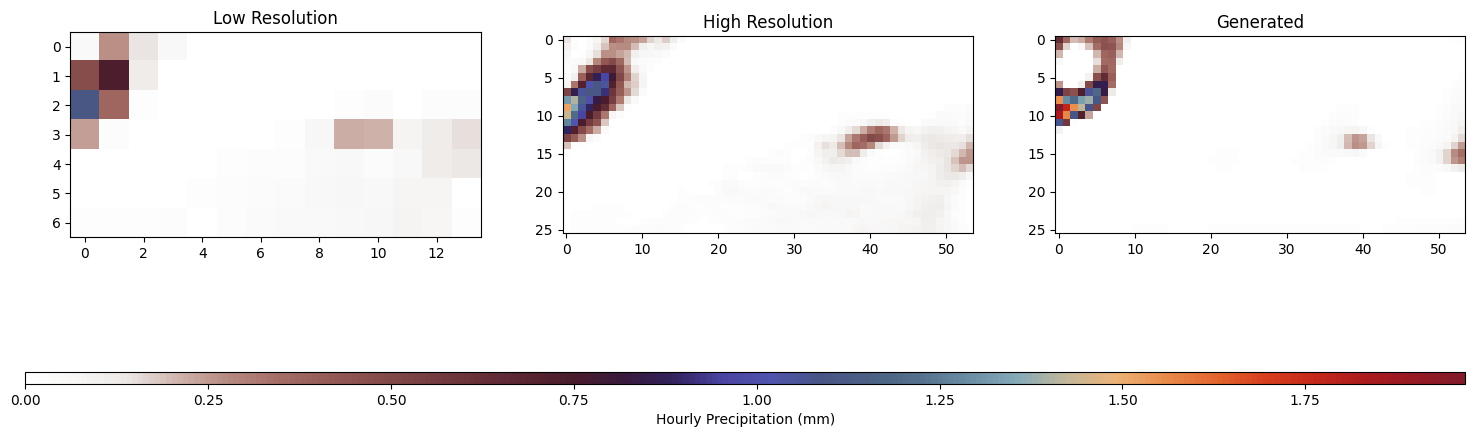

426/426 [==============================] - 16835s 39s/step - d_loss: 1.5644 - g_loss: 1.9028 - gradient_penalty: 0.1513
Epoch 2/30
1/1 [==============================] - 0s 153ms/step d_loss: -0.2519 - g_loss: 2.4100 - gradient_penalty: 0.021


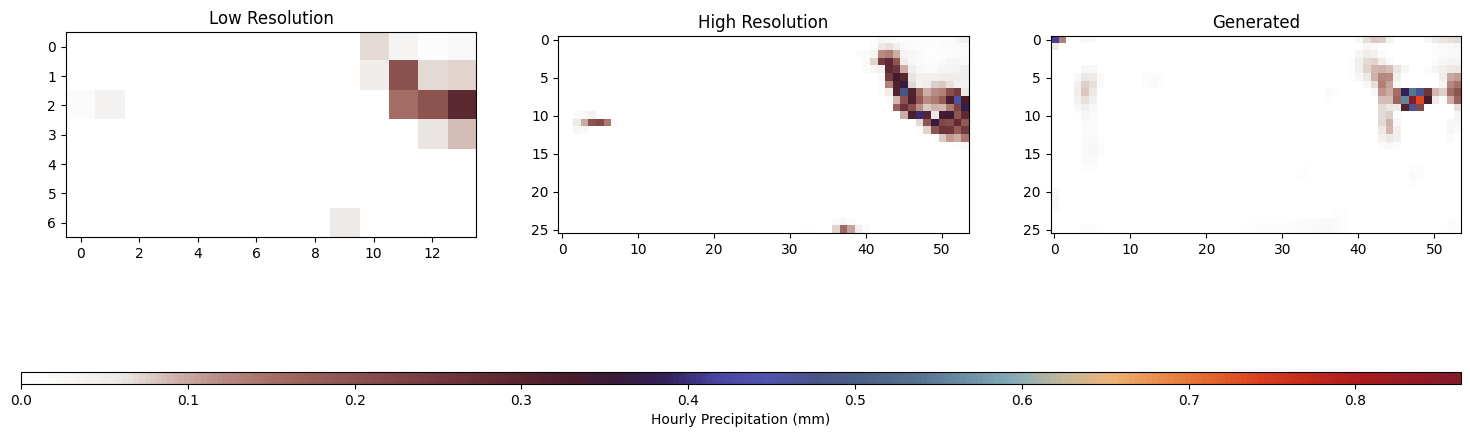

426/426 [==============================] - 14702s 35s/step - d_loss: -0.2509 - g_loss: 2.4075 - gradient_penalty: 0.0211
Epoch 3/30
1/1 [==============================] - 0s 114ms/step d_loss: 27577.1271 - g_loss: 2.2969 - gradient_penalty: 2757.931


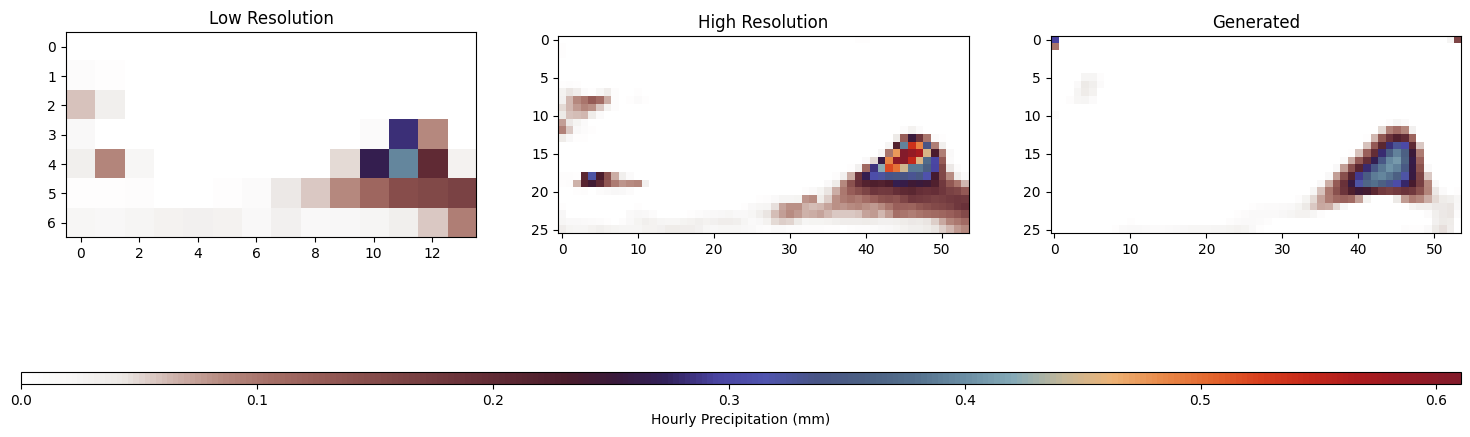

426/426 [==============================] - 15261s 36s/step - d_loss: 27512.5387 - g_loss: 2.2950 - gradient_penalty: 2751.4731
Epoch 4/30
1/1 [==============================] - 0s 104ms/step d_loss: -4.1175 - g_loss: 3.0127 - gradient_penalty: 0.090


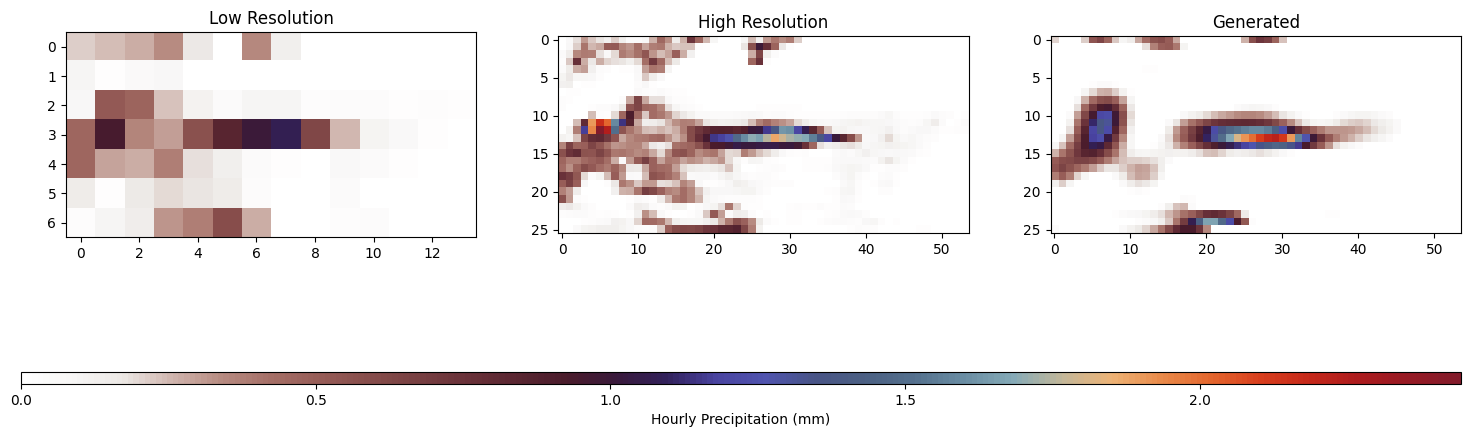

426/426 [==============================] - 13859s 33s/step - d_loss: -4.1159 - g_loss: 3.0151 - gradient_penalty: 0.0905
Epoch 5/30
1/1 [==============================] - 0s 104ms/step d_loss: -6.3650 - g_loss: 4.0978 - gradient_penalty: 0.143


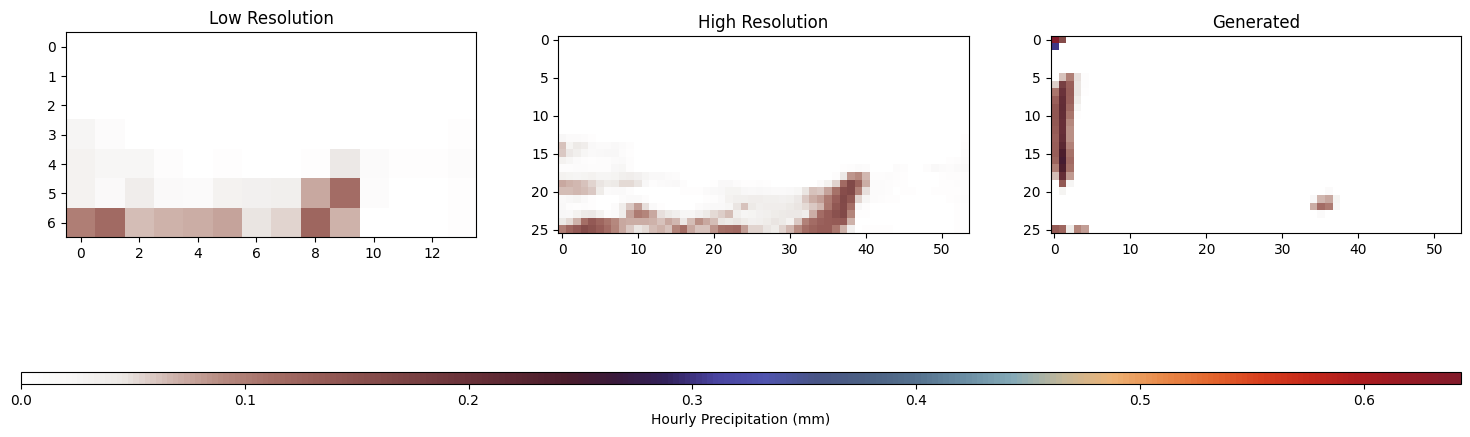

426/426 [==============================] - 13764s 32s/step - d_loss: -6.3598 - g_loss: 4.0845 - gradient_penalty: 0.1433
Epoch 6/30
1/1 [==============================] - 0s 105ms/step d_loss: -6.7636 - g_loss: 5.4767 - gradient_penalty: 0.113


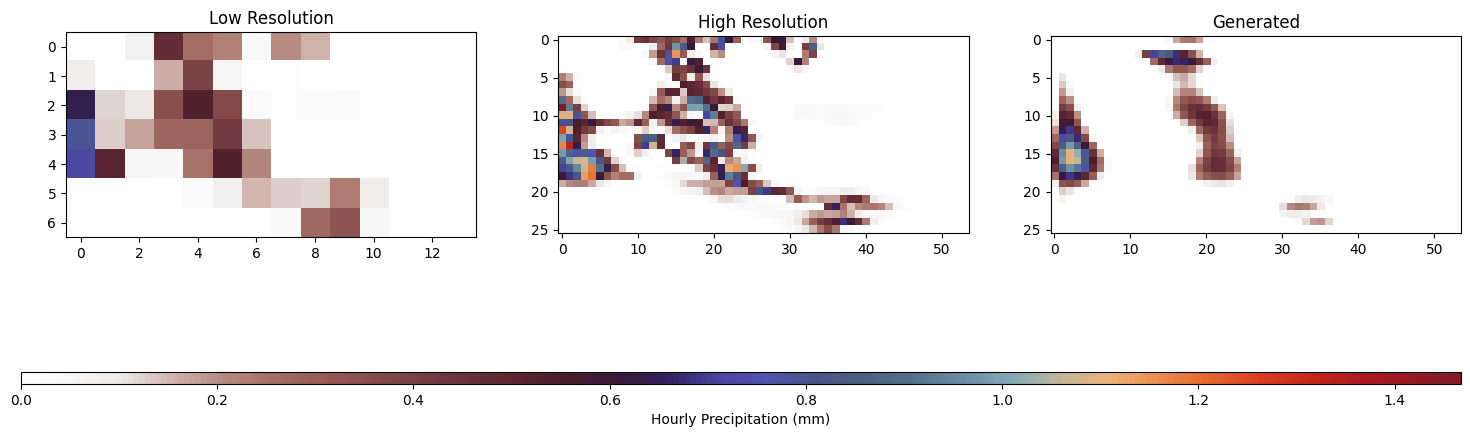

426/426 [==============================] - 13316s 31s/step - d_loss: -6.7603 - g_loss: 5.4730 - gradient_penalty: 0.1131
Epoch 7/30
1/1 [==============================] - 0s 100ms/step d_loss: -7.3642 - g_loss: 6.4676 - gradient_penalty: 0.127


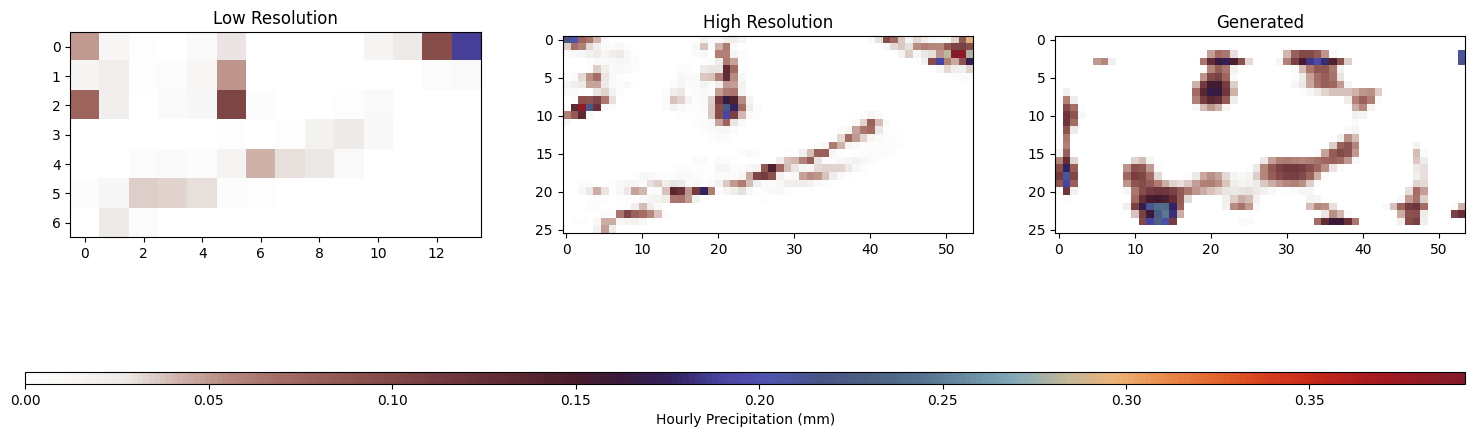

426/426 [==============================] - 13345s 31s/step - d_loss: -7.3576 - g_loss: 6.4627 - gradient_penalty: 0.1277
Epoch 8/30
1/1 [==============================] - 0s 90ms/step- d_loss: -3.9065 - g_loss: 4.1283 - gradient_penalty: 0.352


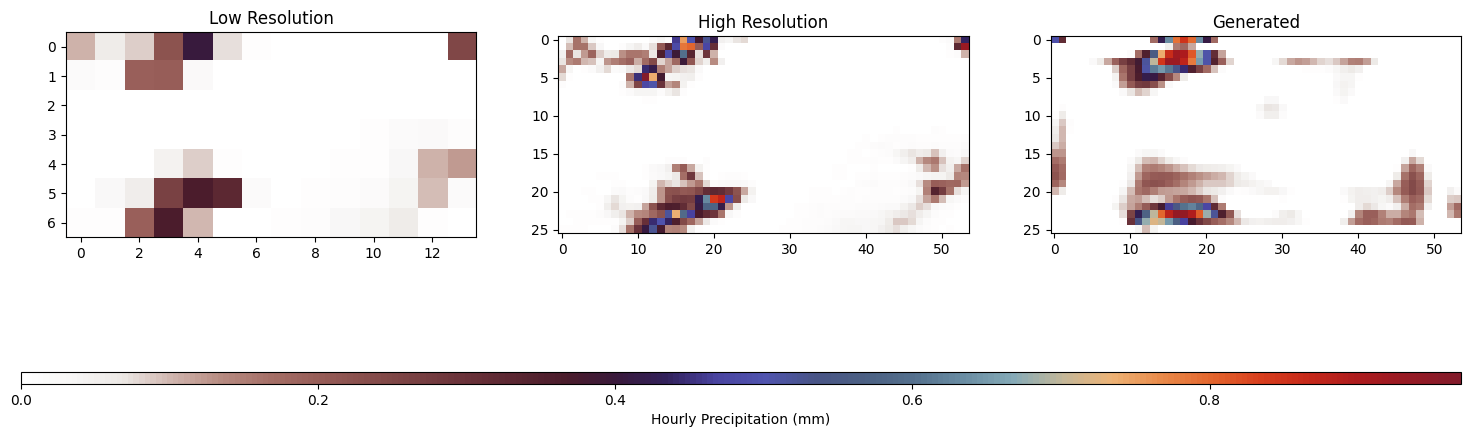

426/426 [==============================] - 14172s 33s/step - d_loss: -3.9096 - g_loss: 4.1228 - gradient_penalty: 0.3520
Epoch 9/30
1/1 [==============================] - 0s 107ms/step d_loss: -6.5291 - g_loss: 8.1399 - gradient_penalty: 0.116


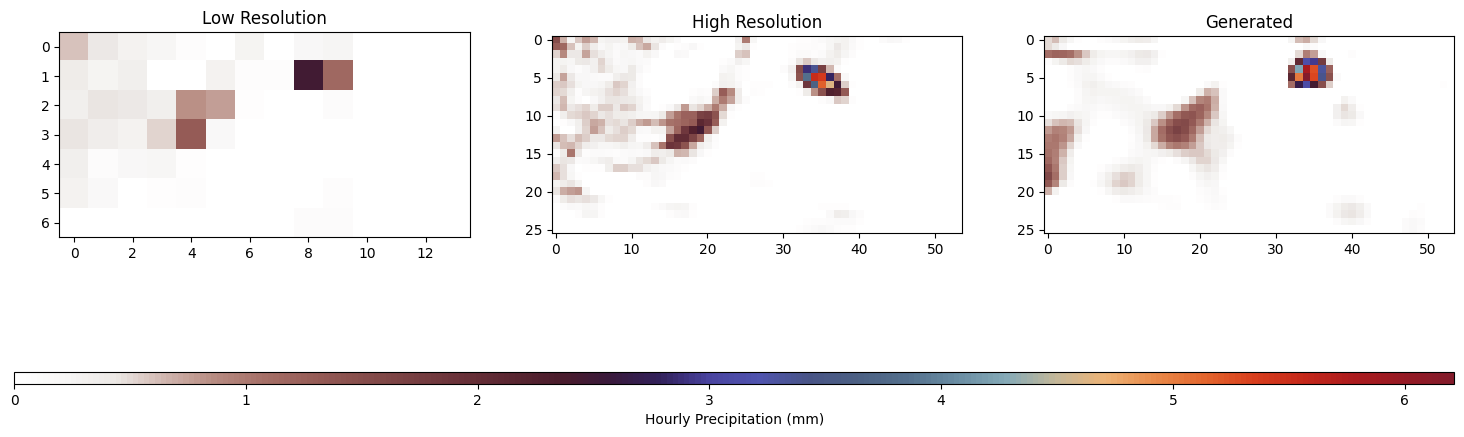

426/426 [==============================] - 13886s 33s/step - d_loss: -6.5326 - g_loss: 8.1671 - gradient_penalty: 0.1164
Epoch 10/30
1/1 [==============================] - 0s 86ms/step- d_loss: -6.2724 - g_loss: 14.8437 - gradient_penalty: 0.147


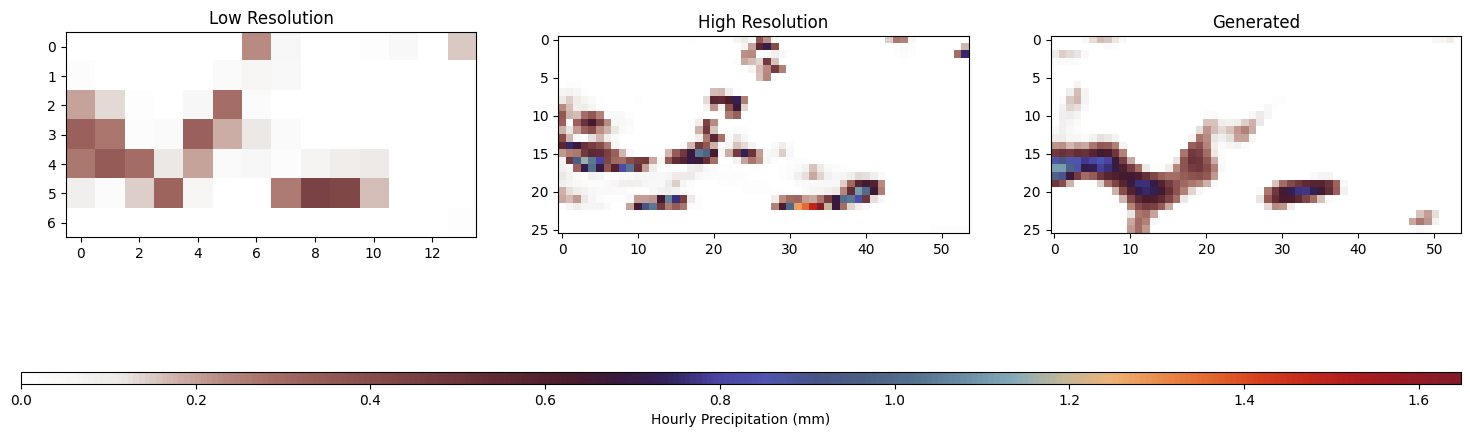

426/426 [==============================] - 12411s 29s/step - d_loss: -6.2627 - g_loss: 14.8397 - gradient_penalty: 0.1471
Epoch 11/30
1/1 [==============================] - 0s 99ms/step- d_loss: -6.4720 - g_loss: 8.2481 - gradient_penalty: 0.112


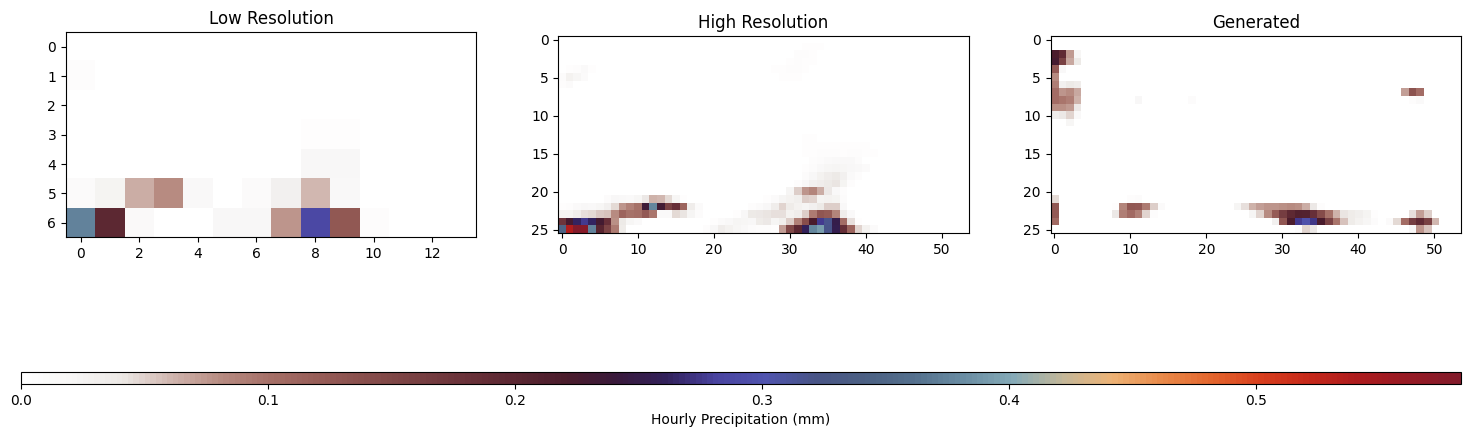

426/426 [==============================] - 13519s 32s/step - d_loss: -6.4696 - g_loss: 8.2555 - gradient_penalty: 0.1118
Epoch 12/30
1/1 [==============================] - 0s 186ms/step d_loss: -5.1259 - g_loss: 12.8865 - gradient_penalty: 0.256


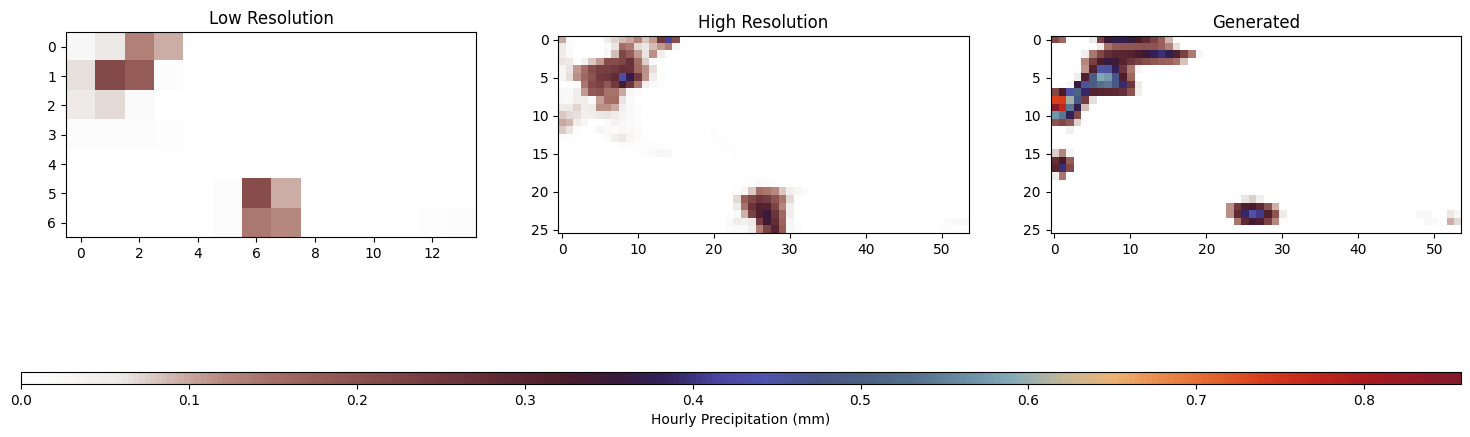

426/426 [==============================] - 14387s 34s/step - d_loss: -5.1235 - g_loss: 12.8927 - gradient_penalty: 0.2563
Epoch 13/30
1/1 [==============================] - 0s 179ms/step d_loss: -6.6210 - g_loss: 12.9835 - gradient_penalty: 0.111


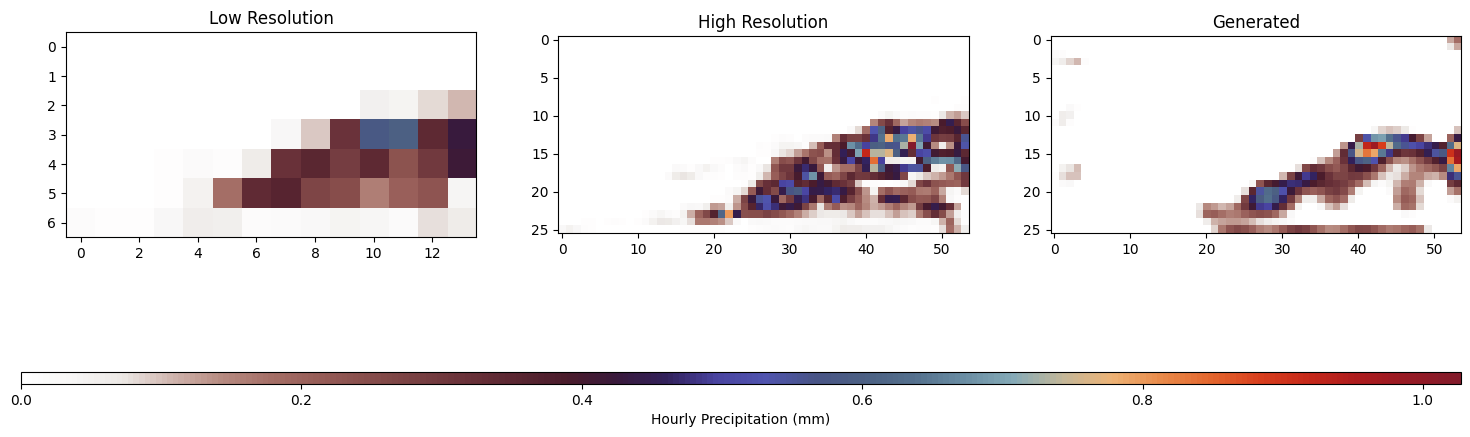

426/426 [==============================] - 15504s 36s/step - d_loss: -6.6193 - g_loss: 12.9870 - gradient_penalty: 0.1117
Epoch 14/30
1/1 [==============================] - 0s 182ms/step d_loss: -6.6966 - g_loss: 9.8118 - gradient_penalty: 0.104


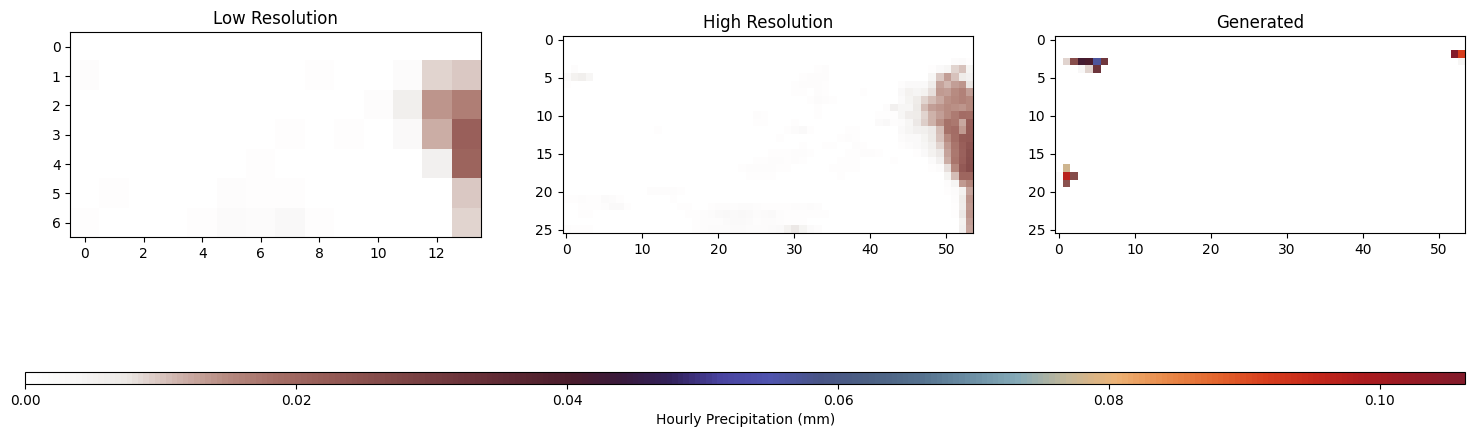

426/426 [==============================] - 15618s 37s/step - d_loss: -6.6969 - g_loss: 9.8156 - gradient_penalty: 0.1044
Epoch 15/30
1/1 [==============================] - 0s 160ms/step d_loss: -6.2523 - g_loss: 10.9526 - gradient_penalty: 0.0935


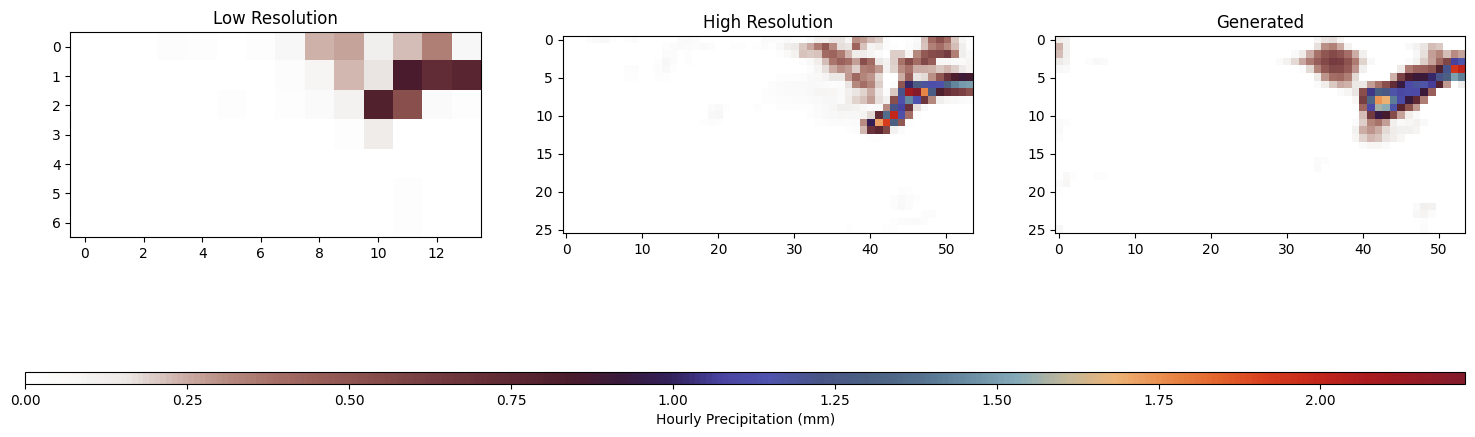

426/426 [==============================] - 49387s 116s/step - d_loss: -6.2460 - g_loss: 10.9639 - gradient_penalty: 0.0934
Epoch 16/30
1/1 [==============================] - 0s 94ms/step- d_loss: -6.9911 - g_loss: 13.3358 - gradient_penalty: 0.109


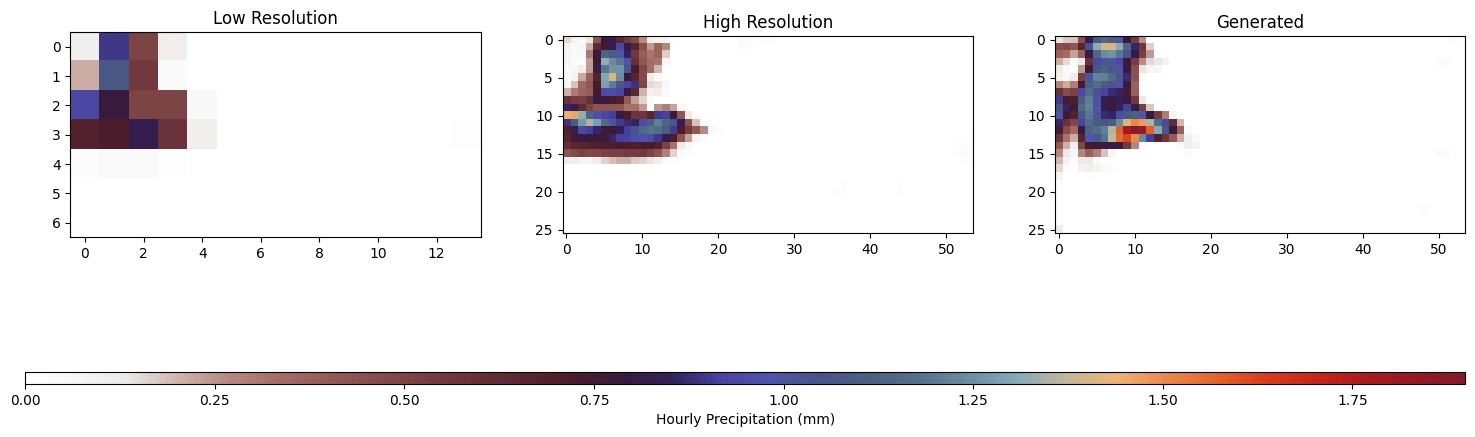

426/426 [==============================] - 12765s 30s/step - d_loss: -6.9899 - g_loss: 13.3535 - gradient_penalty: 0.1090
Epoch 17/30
1/1 [==============================] - 0s 105ms/step d_loss: -6.4611 - g_loss: 15.7399 - gradient_penalty: 0.156


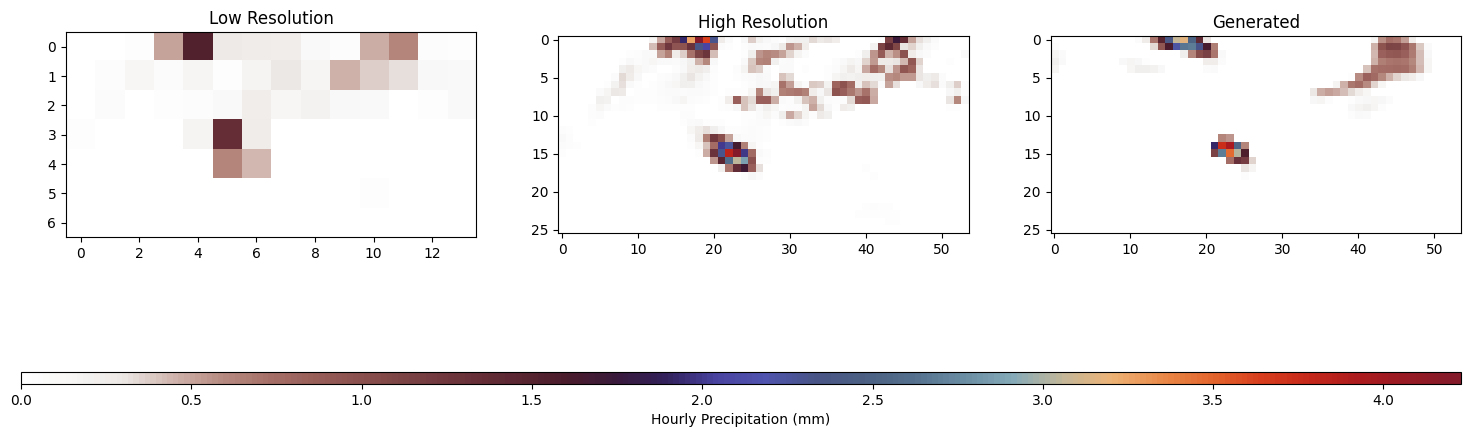

426/426 [==============================] - 11935s 28s/step - d_loss: -6.4621 - g_loss: 15.7617 - gradient_penalty: 0.1564
Epoch 18/30
1/1 [==============================] - 0s 125ms/step d_loss: -6.6179 - g_loss: 22.6748 - gradient_penalty: 0.117


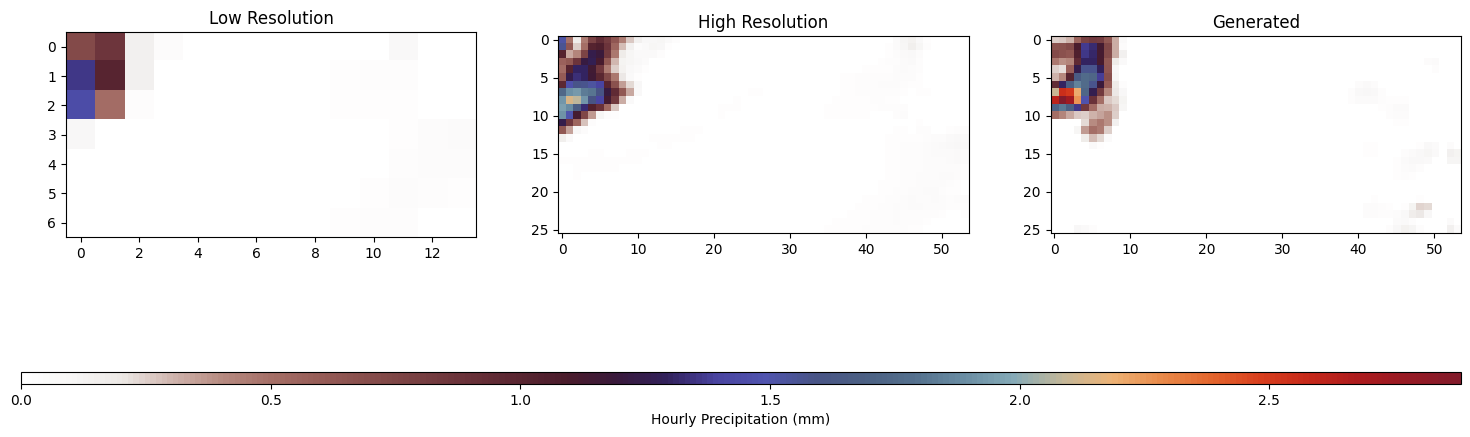

426/426 [==============================] - 13032s 31s/step - d_loss: -6.6132 - g_loss: 22.6866 - gradient_penalty: 0.1172
Epoch 19/30
1/1 [==============================] - 0s 214ms/step d_loss: -6.1878 - g_loss: 24.7173 - gradient_penalty: 0.1324


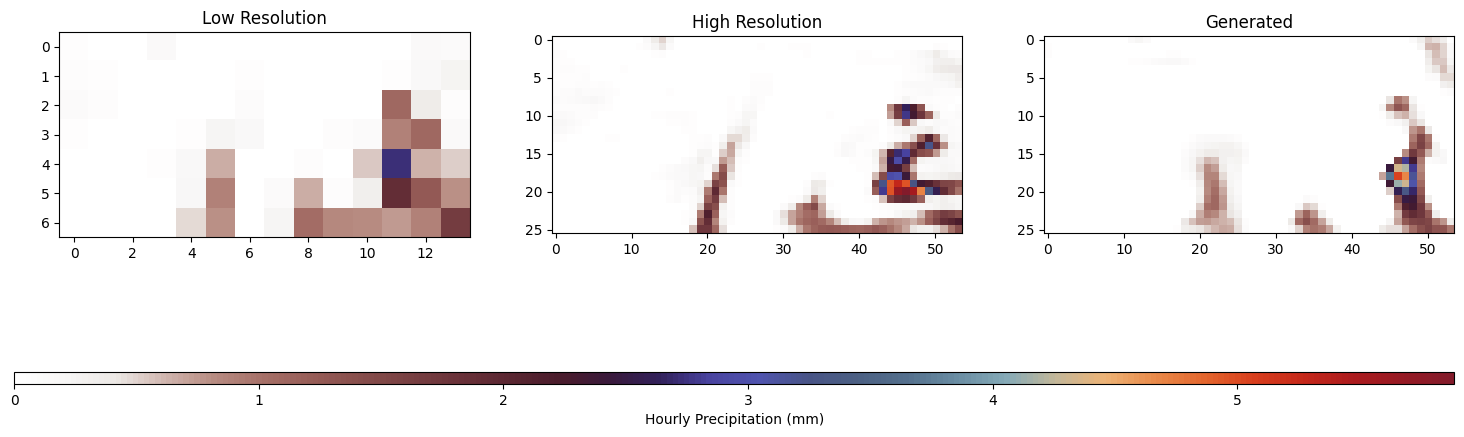

426/426 [==============================] - 43541s 102s/step - d_loss: -6.1869 - g_loss: 24.7156 - gradient_penalty: 0.1323
Epoch 20/30
1/1 [==============================] - 0s 189ms/step d_loss: 21263.4560 - g_loss: 31.9174 - gradient_penalty: 2127.058


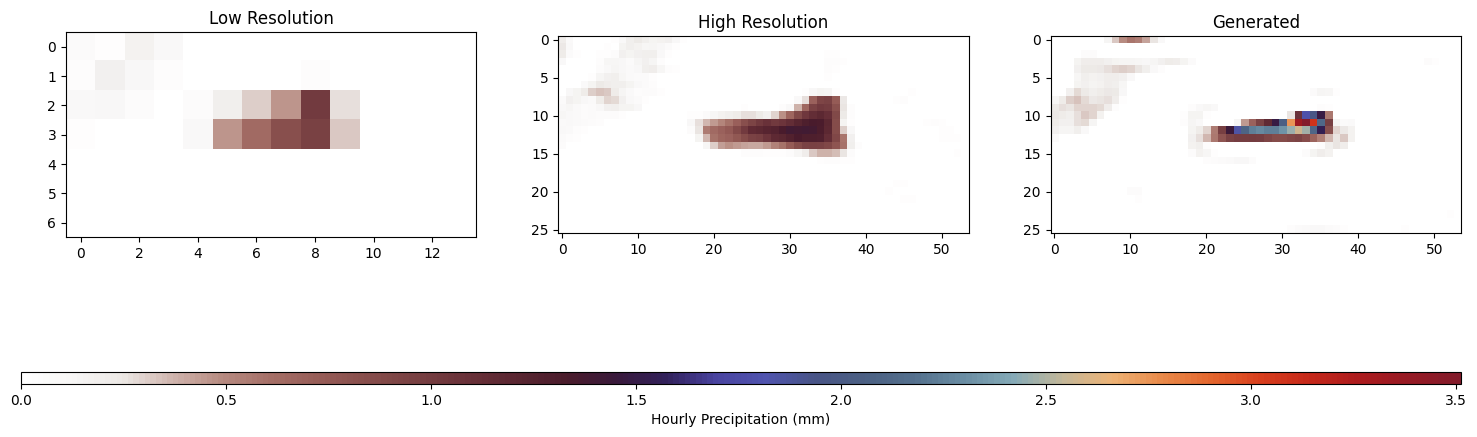

426/426 [==============================] - 16252s 38s/step - d_loss: 21213.6488 - g_loss: 31.9498 - gradient_penalty: 2122.0774
Epoch 21/30
1/1 [==============================] - 0s 170ms/step d_loss: -5.7784 - g_loss: 36.4706 - gradient_penalty: 0.093


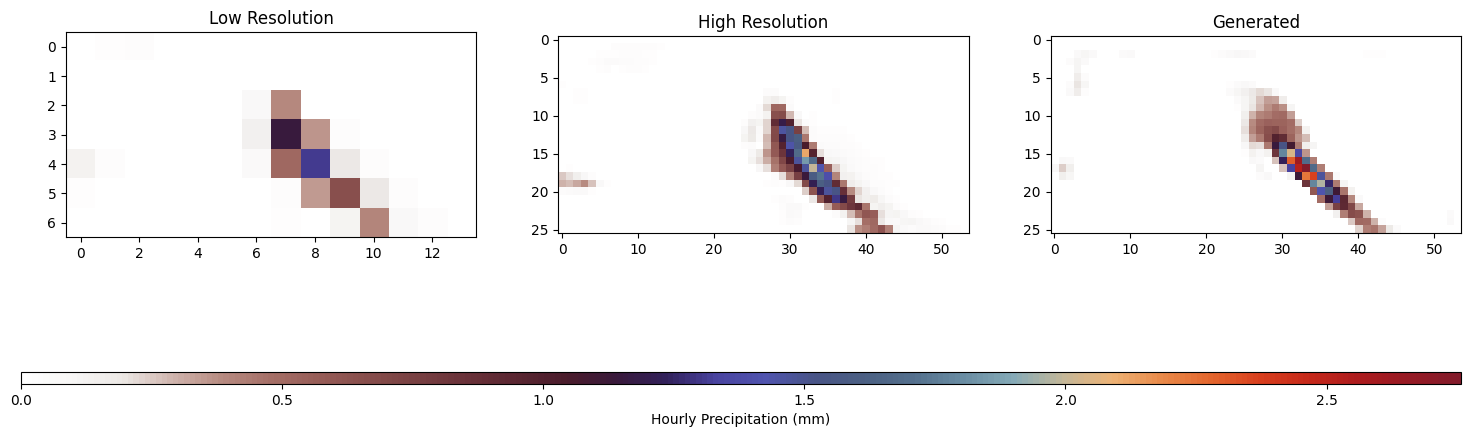

426/426 [==============================] - 25072s 59s/step - d_loss: -5.7779 - g_loss: 36.4847 - gradient_penalty: 0.0932
Epoch 22/30
1/1 [==============================] - 0s 176ms/step d_loss: -4.7535 - g_loss: 31.0649 - gradient_penalty: 0.153


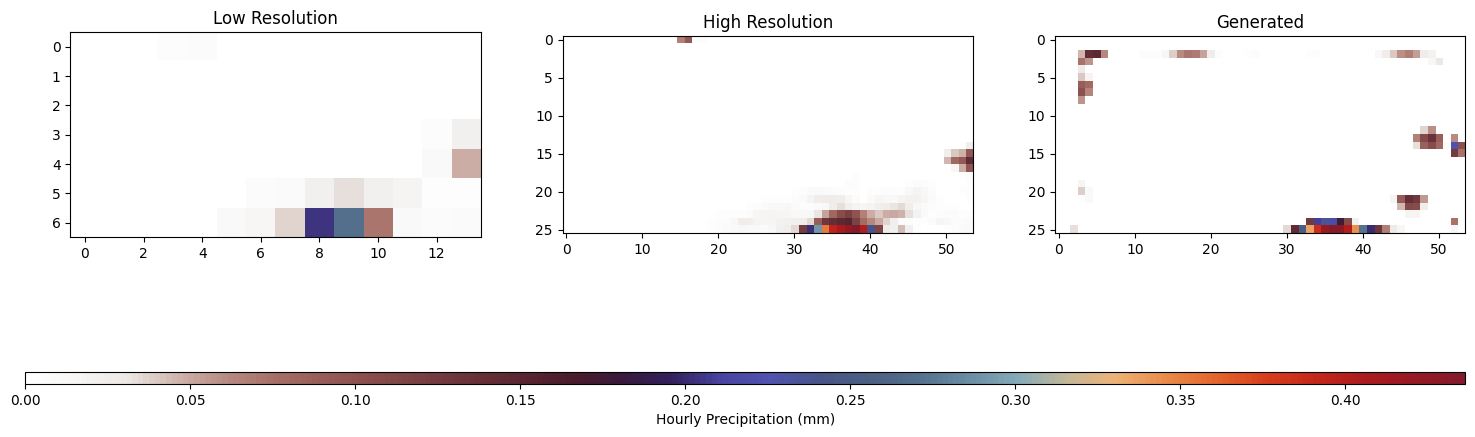

426/426 [==============================] - 13523s 32s/step - d_loss: -4.7508 - g_loss: 31.0566 - gradient_penalty: 0.1527
Epoch 23/30
1/1 [==============================] - 0s 194ms/step d_loss: -5.2992 - g_loss: 28.4186 - gradient_penalty: 0.079


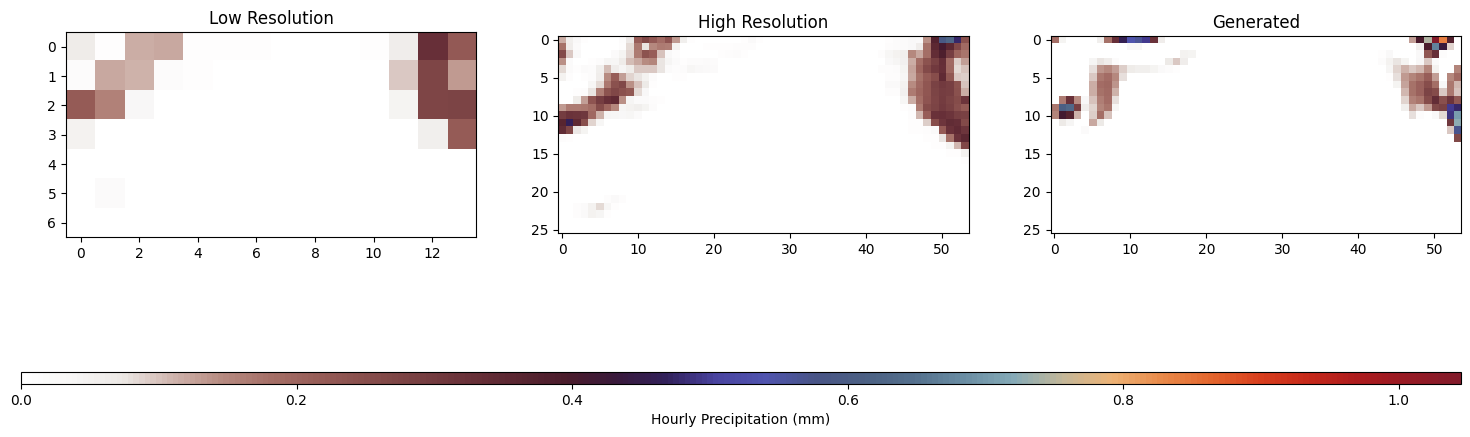

426/426 [==============================] - 11274s 26s/step - d_loss: -5.2948 - g_loss: 28.4568 - gradient_penalty: 0.0797
Epoch 24/30
1/1 [==============================] - 0s 209ms/step d_loss: -5.2798 - g_loss: 30.3322 - gradient_penalty: 0.090


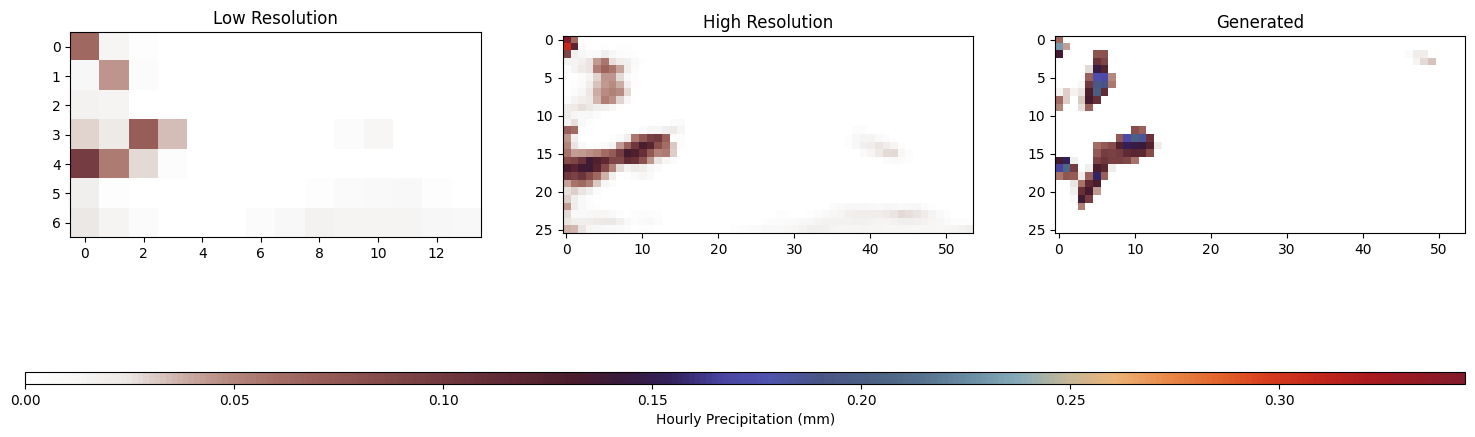

426/426 [==============================] - 11442s 27s/step - d_loss: -5.2764 - g_loss: 30.3188 - gradient_penalty: 0.0899
Epoch 25/30
1/1 [==============================] - 0s 192ms/step d_loss: -5.2669 - g_loss: 25.4964 - gradient_penalty: 0.092


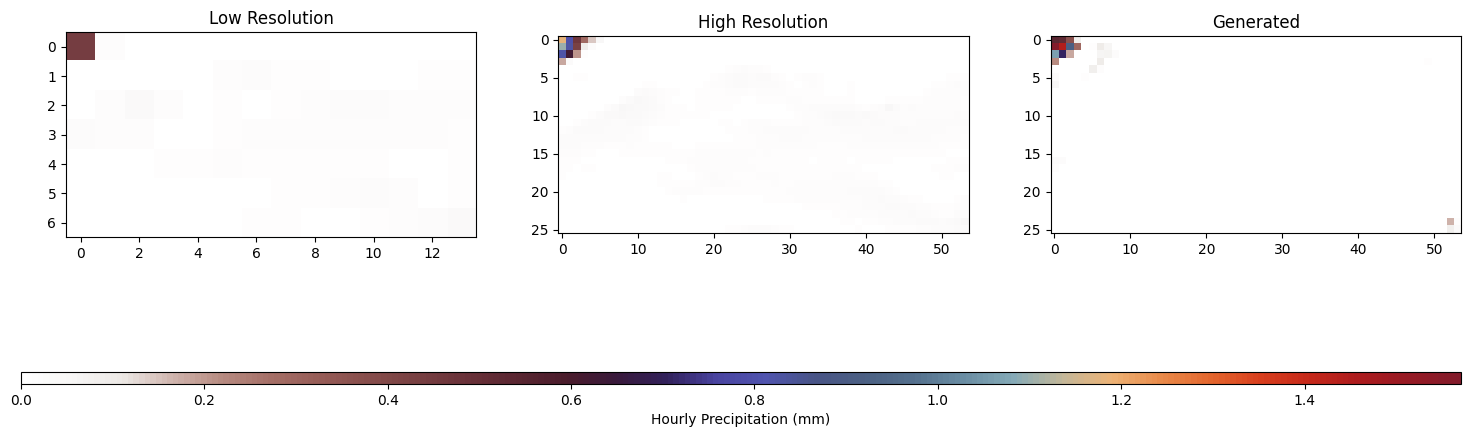

426/426 [==============================] - 12385s 29s/step - d_loss: -5.2645 - g_loss: 25.5224 - gradient_penalty: 0.0926
Epoch 26/30
1/1 [==============================] - 0s 221ms/step d_loss: -5.3907 - g_loss: 30.2598 - gradient_penalty: 0.085


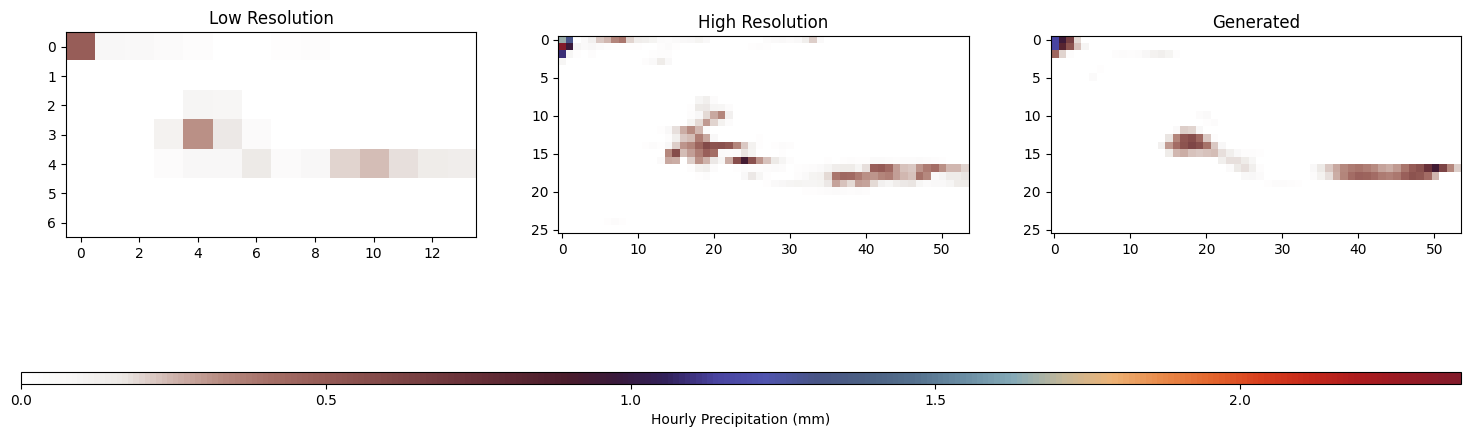

426/426 [==============================] - 17164s 40s/step - d_loss: -5.3863 - g_loss: 30.2757 - gradient_penalty: 0.0855
Epoch 27/30
1/1 [==============================] - 0s 183ms/step d_loss: -5.7103 - g_loss: 30.5011 - gradient_penalty: 0.089


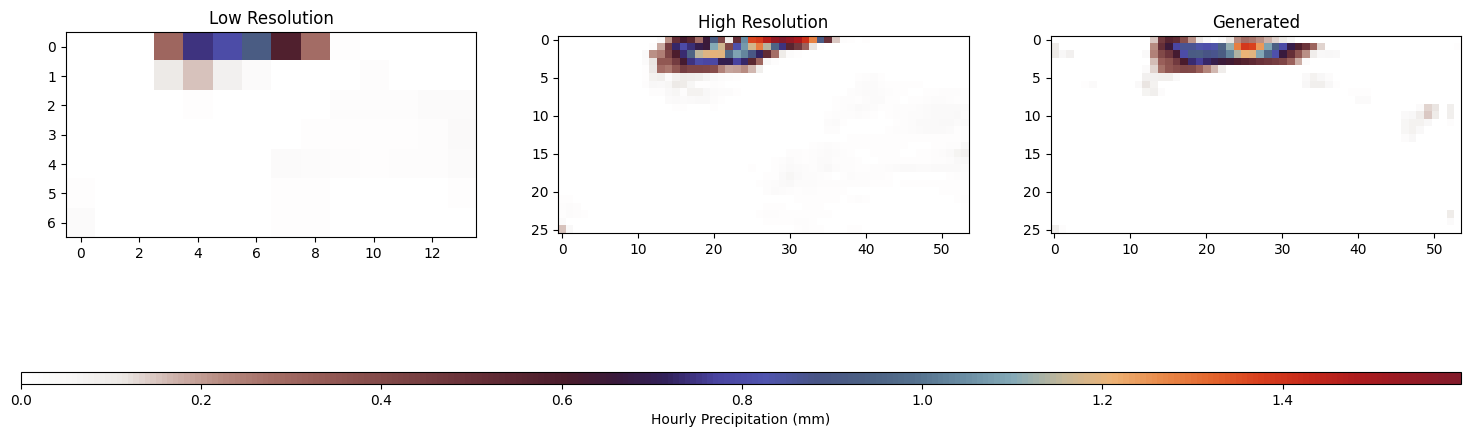

426/426 [==============================] - 14073s 33s/step - d_loss: -5.7066 - g_loss: 30.4981 - gradient_penalty: 0.0893
Epoch 28/30
1/1 [==============================] - 0s 201ms/step d_loss: -5.7264 - g_loss: 29.2332 - gradient_penalty: 0.108


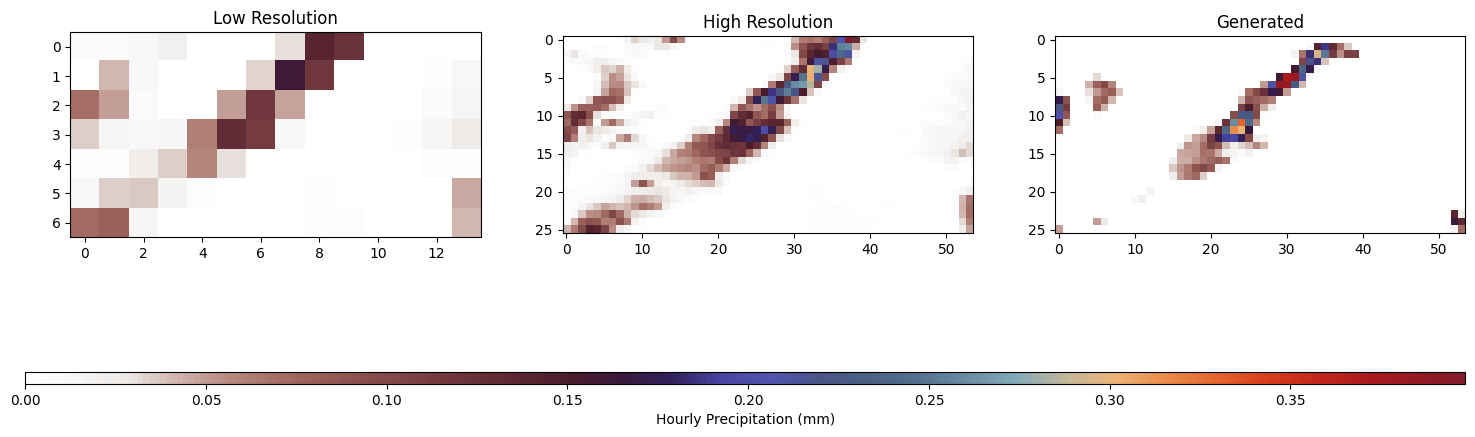

426/426 [==============================] - 12912s 30s/step - d_loss: -5.7238 - g_loss: 29.2465 - gradient_penalty: 0.1088
Epoch 29/30
1/1 [==============================] - 0s 150ms/step d_loss: -5.7052 - g_loss: 29.7413 - gradient_penalty: 0.096


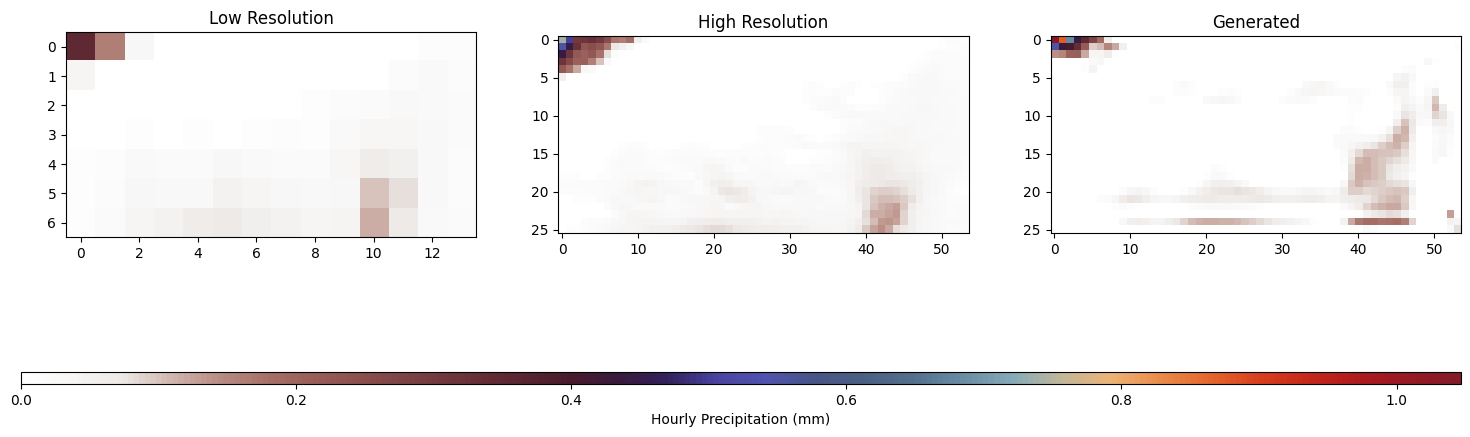

426/426 [==============================] - 12997s 30s/step - d_loss: -5.7009 - g_loss: 29.7189 - gradient_penalty: 0.0963
Epoch 30/30
1/1 [==============================] - 0s 142ms/step d_loss: -5.6372 - g_loss: 29.3118 - gradient_penalty: 0.112


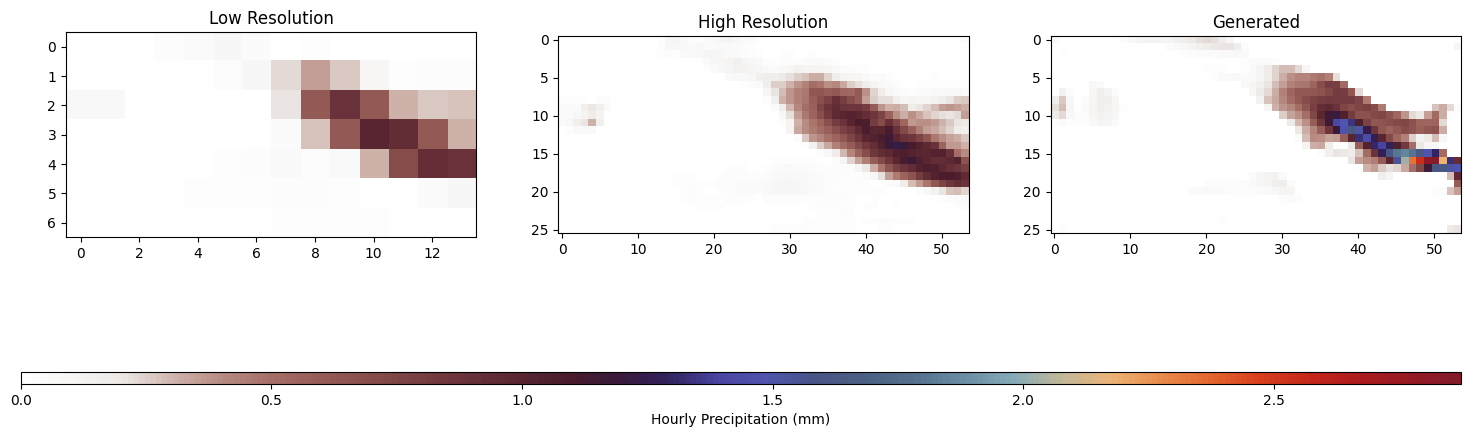

426/426 [==============================] - 13061s 31s/step - d_loss: -5.6329 - g_loss: 29.3374 - gradient_penalty: 0.1124


In [10]:
# Fit model
wgan.fit(batches, epochs=epochs, shuffle=True, callbacks=[csv_logger, plot_callback])


In [11]:

# Save the model

generator.save("./Outputs/WGAN_NZ_DT.keras")

Now, the part of reading the saved model and generating prediction starts

In [5]:
#Import pretrained Generator
# Import required libraries
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input
from tensorflow.keras.models import load_model

# Define the ReflectionPadding2D custom layer
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super().__init__(**kwargs)
        self.padding = padding

    def call(self, inputs):
        return tf.pad(
            inputs,
            [[0, 0], [self.padding[0], self.padding[0]], [self.padding[1], self.padding[1]], [0, 0]],
            mode="REFLECT"
        )

# Define the residual_block function
def residual_block(x, filters, kernel_size=3, stride=1, padding='same', l2_reg=0.001):
    from tensorflow.keras import layers
    shortcut = x
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding=padding,
                      kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding=padding,
                      kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding=padding,
                                 kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.Activation('relu')(x)
    return x

# Define the leaky_relu_with_slope function
def leaky_relu_with_slope(x):
    from tensorflow.keras import layers
    return layers.LeakyReLU(alpha=0.2)(x)

# Load the model with all required custom objects
generator = load_model(
    './Outputs/WGAN_NZ_DT.keras',
    custom_objects={
        'ReflectionPadding2D': ReflectionPadding2D,
        'residual_block': residual_block,
        'leaky_relu_with_slope': leaky_relu_with_slope
    },
    safe_mode=False
)

# Print the model summary
generator.summary()

# Test the loaded model
noise_shape = Xtest.shape[:1] + Xtest.shape[2:]
random_noise = np.random.normal(0, 1, noise_shape)

loss,acc = generator.evaluate([Xtest,random_noise], Ytest)
print('Restored model, MSE: ', loss)
print('Restored model, MAE: ', acc)

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 noise_input (InputLayer)    [(None, 7, 14, 1)]           0         []                            
                                                                                                  
 low_res_input (InputLayer)  [(None, 24, 7, 14, 1)]       0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 7, 14, 16)            32        ['noise_input[0][0]']         
                                                                                                  
 time_distributed_34 (TimeD  (None, 24, 7, 14, 16)        160       ['low_res_input[0][0]']       
 istributed)                                                                              

In [12]:
# Generate predictions and reshape them to match the high-res shape
# Generate noise without the time dimension
noise_input = np.random.normal(0, 1, (Xtest.shape[0], Xtest.shape[2], Xtest.shape[3], Xtest.shape[4]))

# Generate predictions
test_predictions = generator.predict([Xtest, noise_input])

print(test_predictions.shape)

213/213 [==============================] - 176s 826ms/step
(6805, 24, 26, 54, 1)


In [13]:
#save output to NC files to do analysis in R

import os
import numpy as np
from netCDF4 import Dataset

# Define your dimensions
time_dim = 24
lat_dim = 26
lon_dim = 54

# Latitude and longitude arrays (customize as needed)
latitudes = np.linspace(48.25, 48.25 + (lat_dim - 1) * 0.5, lat_dim)
longitudes = np.linspace(-120.75, -120.75 + (lon_dim - 1) * 0.5, lon_dim)

# Directory to save the files
output_dir = "nc_files_wganG30_hope3"
os.makedirs(output_dir, exist_ok=True)

# Loop through each of the 400 samples in test_predictions
for i in range(test_predictions.shape[0]):
    # File name
    file_name = os.path.join(output_dir, f"sample_{i+1}.nc")
    
    # Create the NetCDF file
    with Dataset(file_name, "w", format="NETCDF4") as ncfile:
        # Create dimensions
        ncfile.createDimension("time", time_dim)
        ncfile.createDimension("lat", lat_dim)
        ncfile.createDimension("lon", lon_dim)
        
        # Create variables
        times = ncfile.createVariable("time", "i4", ("time",))
        lats = ncfile.createVariable("lat", "f4", ("lat",))
        lons = ncfile.createVariable("lon", "f4", ("lon",))
        precipitation = ncfile.createVariable("precipitation", "f4", ("time", "lat", "lon"))
        
        # Add metadata (optional)
        ncfile.description = "Test predictions for precipitation downscaling"
        #ncfile.history = "Created on " + Dataset.date.today().strftime("%Y-%m-%d")
        lats.units = "degrees_north"
        lons.units = "degrees_east"
        precipitation.units = "mm/hr"  # Replace with actual units if different
        
        # Assign values to the variables
        times[:] = np.arange(time_dim)  # Replace with actual time values if needed
        lats[:] = latitudes
        lons[:] = longitudes
        precipitation[:, :, :] = test_predictions[i, :, :, :, 0]  # Extract the sample data
        
    print(f"Saved {file_name}")


Saved nc_files_wganG30_hope3\sample_1.nc
Saved nc_files_wganG30_hope3\sample_2.nc
Saved nc_files_wganG30_hope3\sample_3.nc
Saved nc_files_wganG30_hope3\sample_4.nc
Saved nc_files_wganG30_hope3\sample_5.nc
Saved nc_files_wganG30_hope3\sample_6.nc
Saved nc_files_wganG30_hope3\sample_7.nc
Saved nc_files_wganG30_hope3\sample_8.nc
Saved nc_files_wganG30_hope3\sample_9.nc
Saved nc_files_wganG30_hope3\sample_10.nc
Saved nc_files_wganG30_hope3\sample_11.nc
Saved nc_files_wganG30_hope3\sample_12.nc
Saved nc_files_wganG30_hope3\sample_13.nc
Saved nc_files_wganG30_hope3\sample_14.nc
Saved nc_files_wganG30_hope3\sample_15.nc
Saved nc_files_wganG30_hope3\sample_16.nc
Saved nc_files_wganG30_hope3\sample_17.nc
Saved nc_files_wganG30_hope3\sample_18.nc
Saved nc_files_wganG30_hope3\sample_19.nc
Saved nc_files_wganG30_hope3\sample_20.nc
Saved nc_files_wganG30_hope3\sample_21.nc
Saved nc_files_wganG30_hope3\sample_22.nc
Saved nc_files_wganG30_hope3\sample_23.nc
Saved nc_files_wganG30_hope3\sample_24.nc
S

Plotting sample index: 234


C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


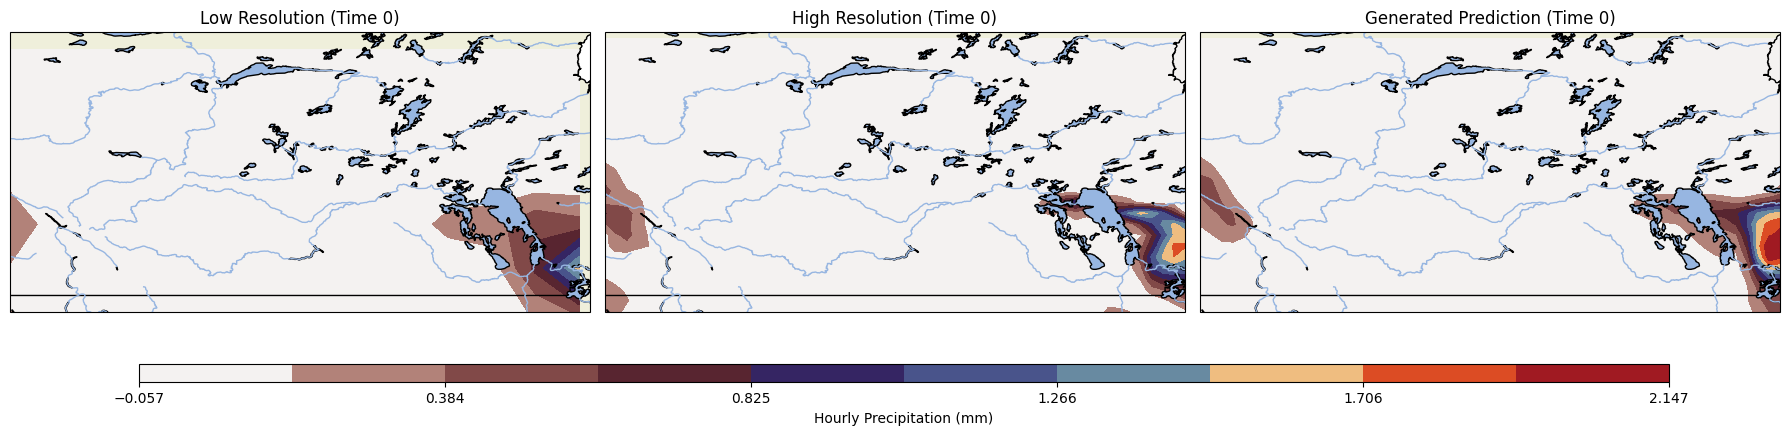

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


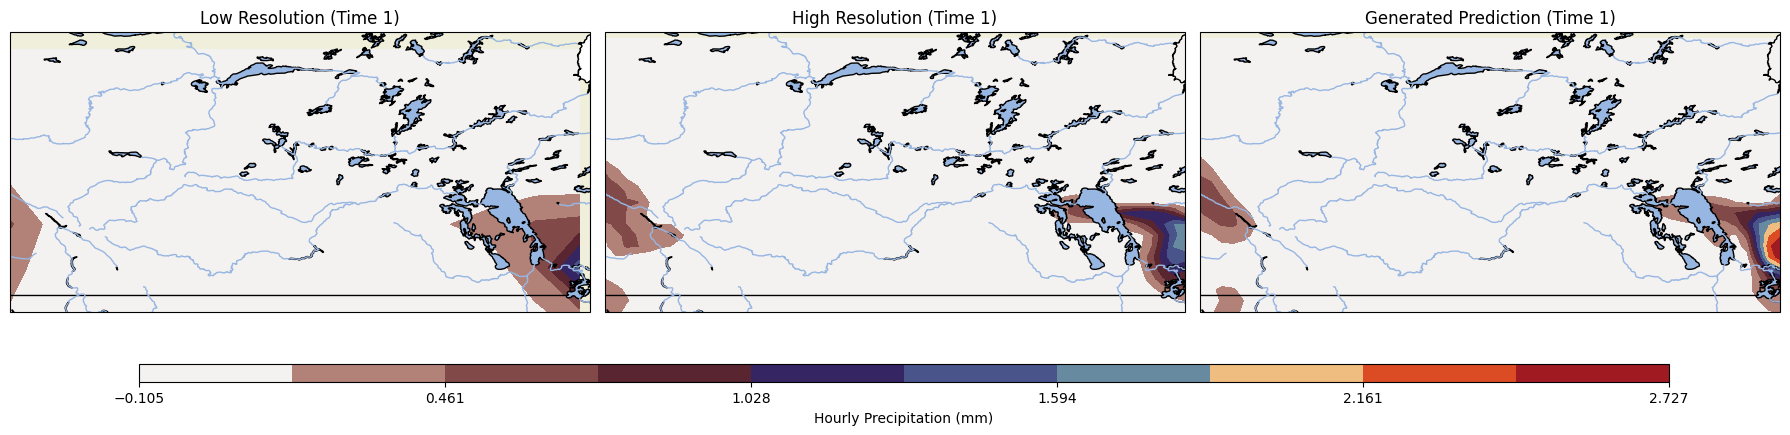

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


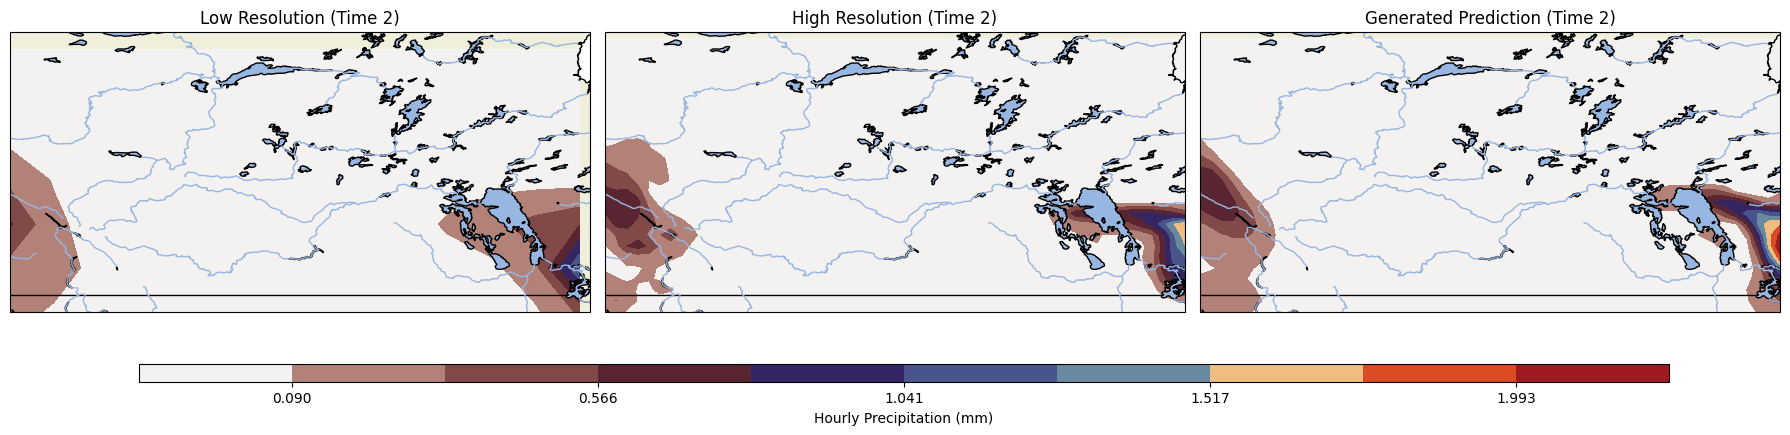

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


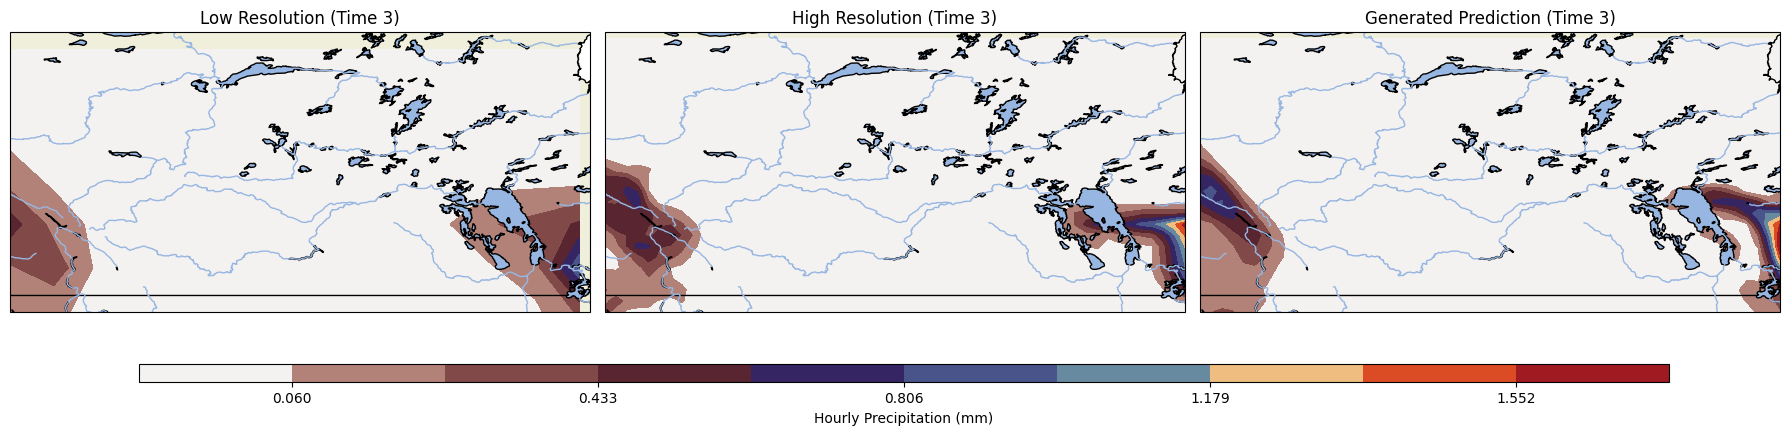

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


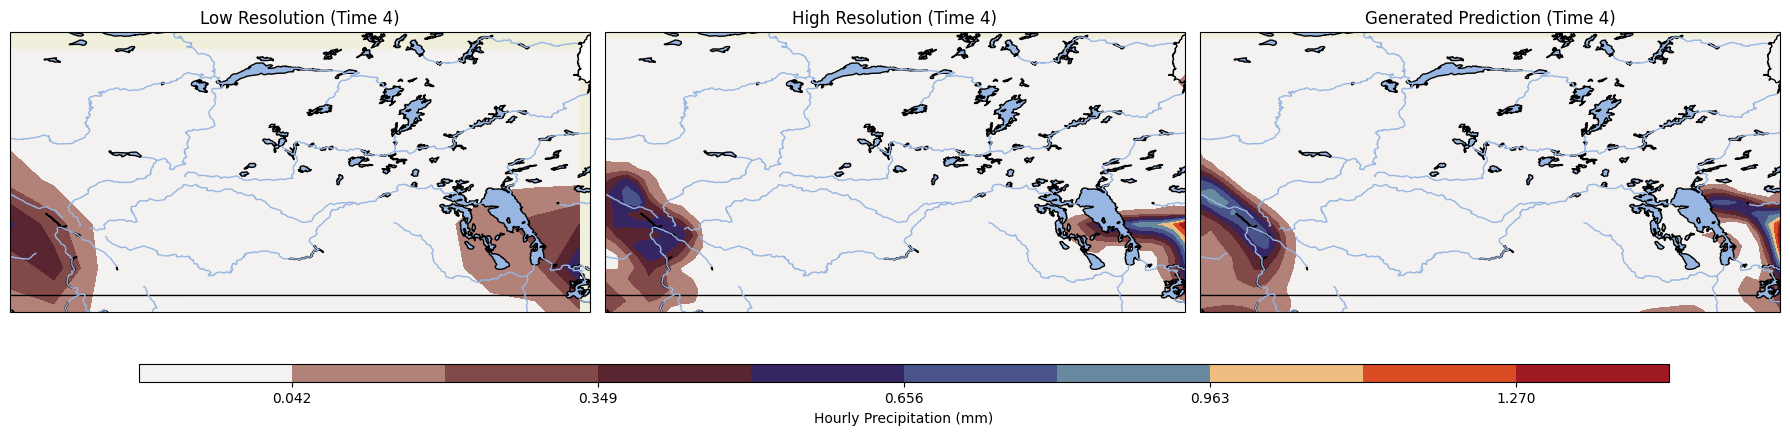

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


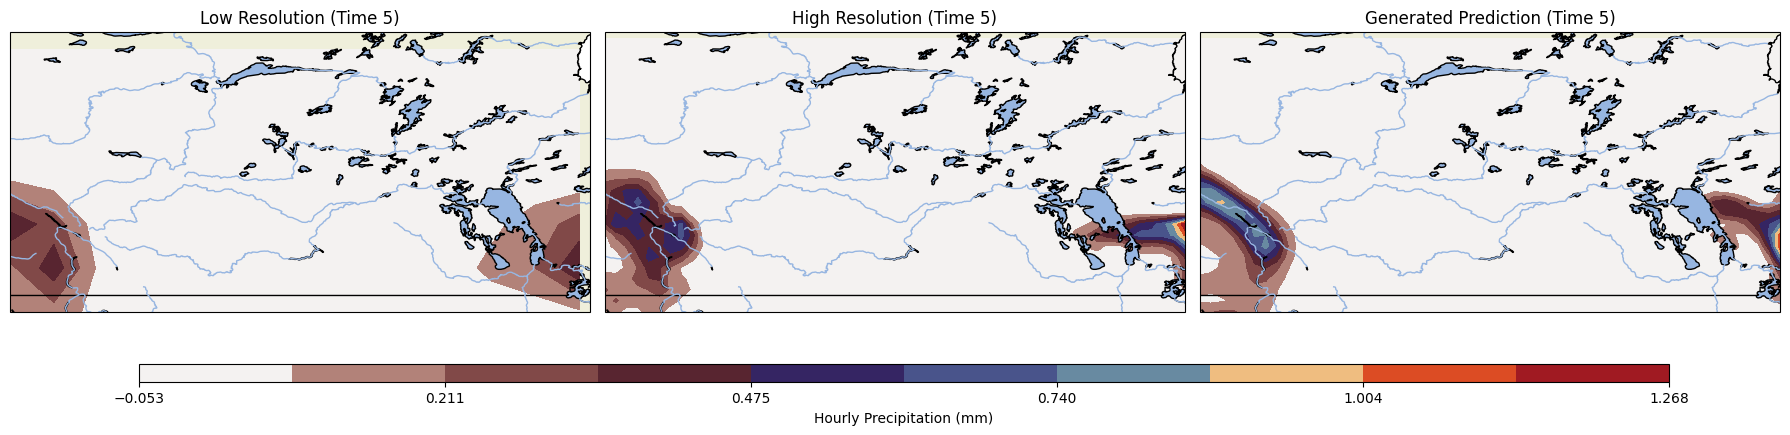

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


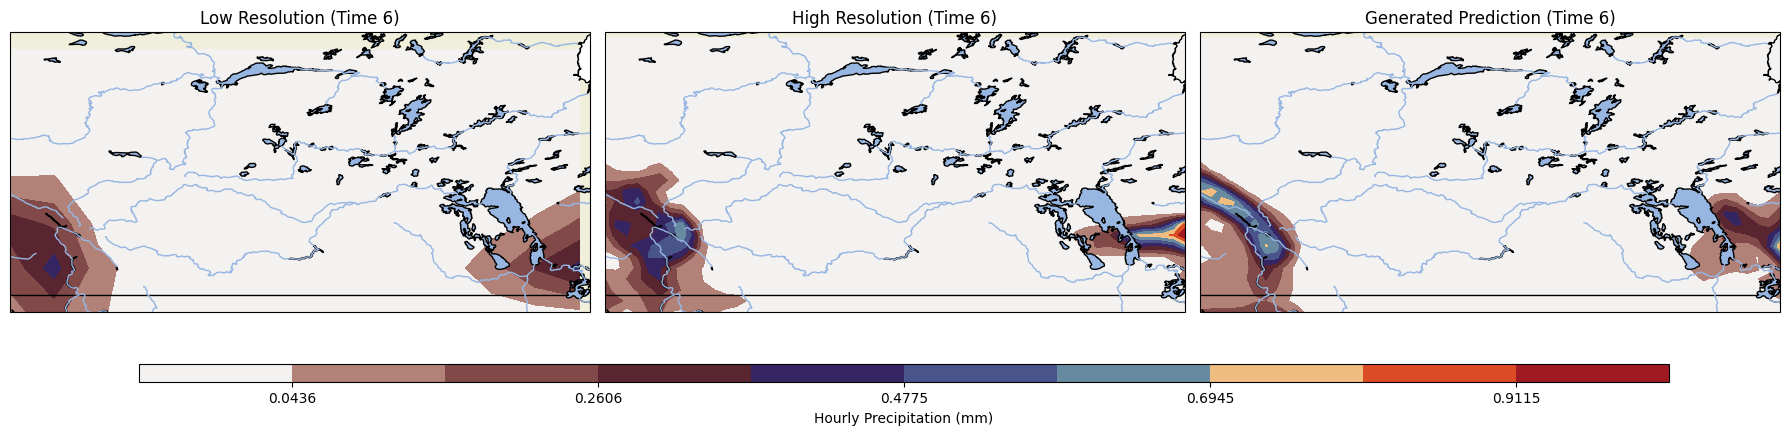

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


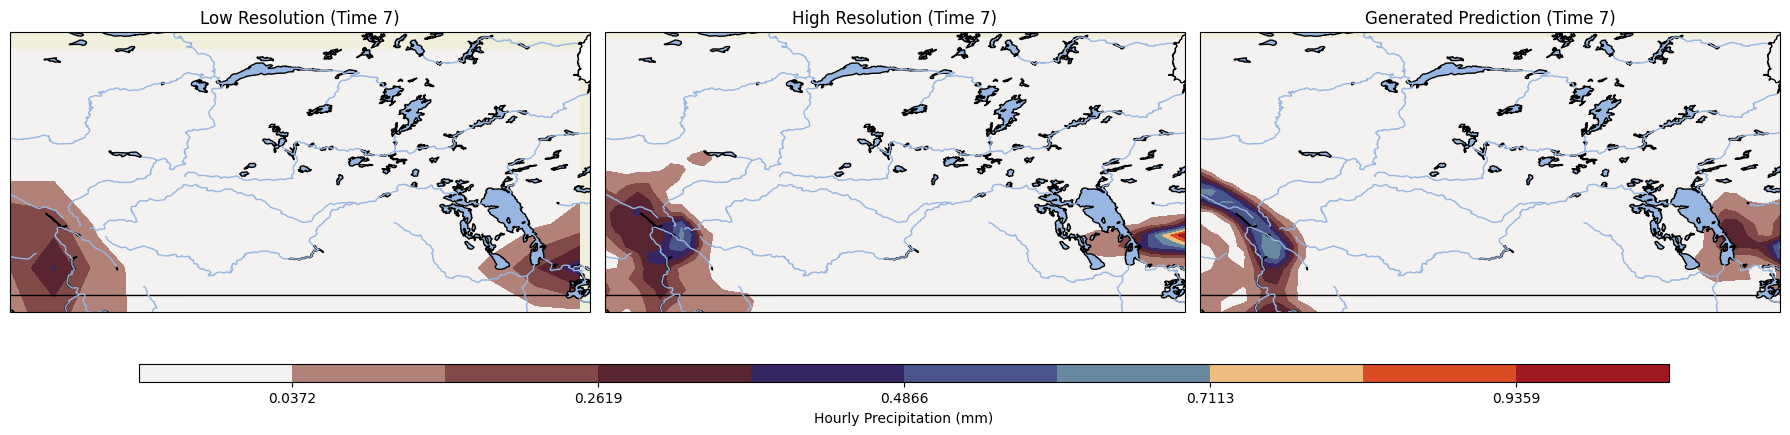

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


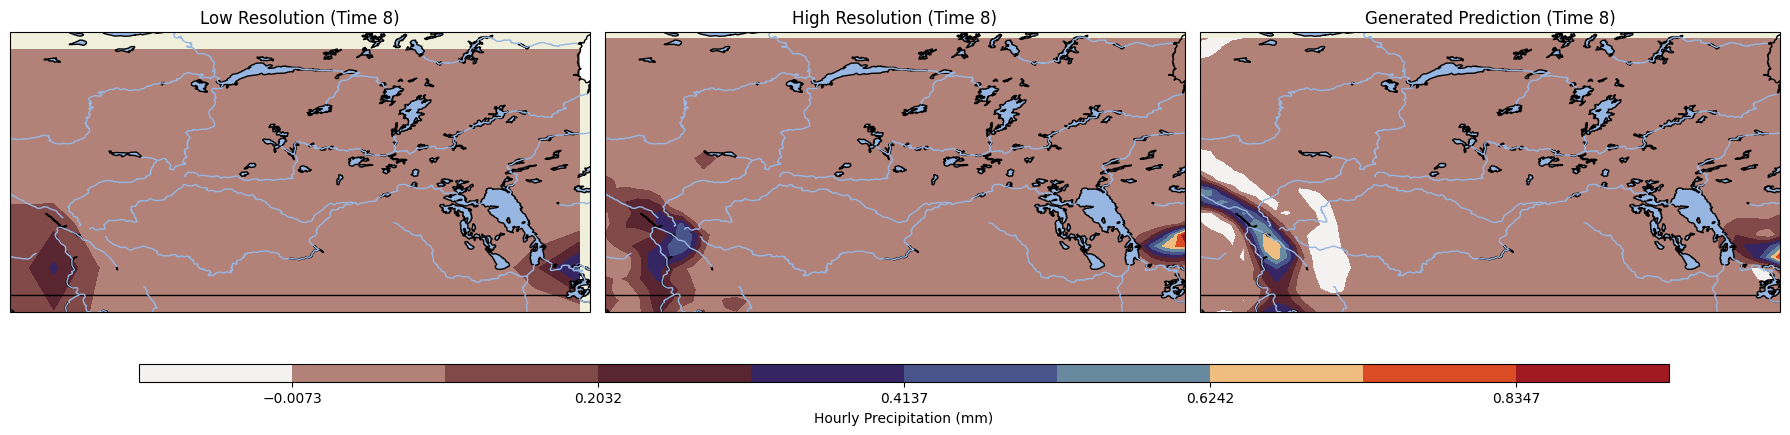

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


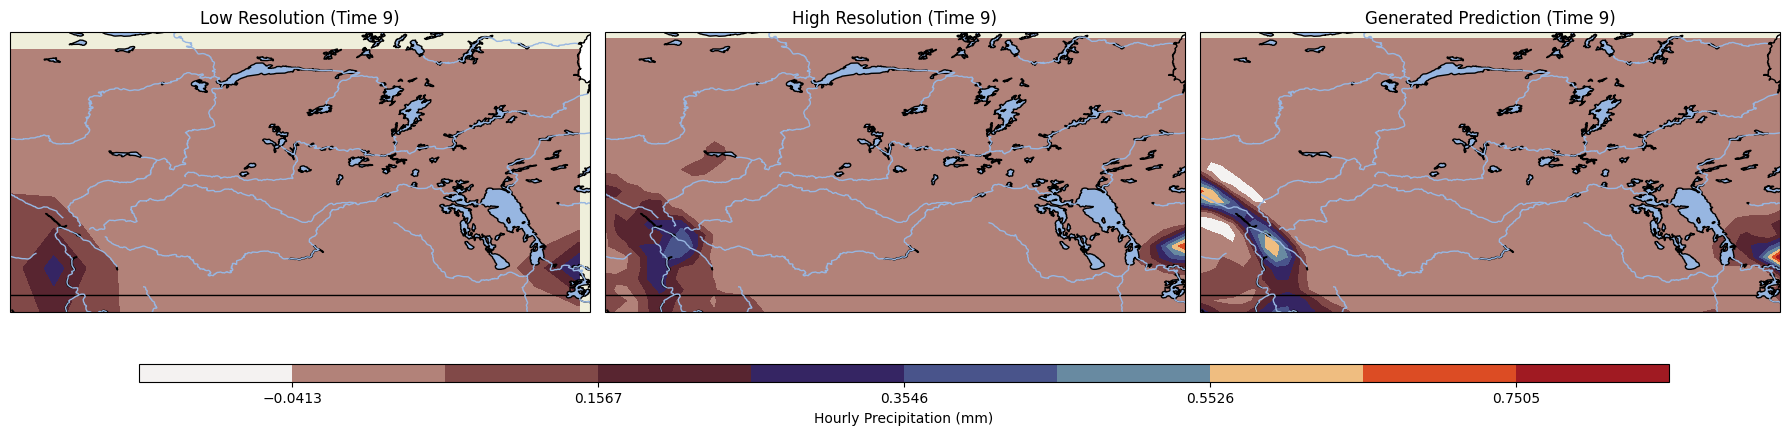

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


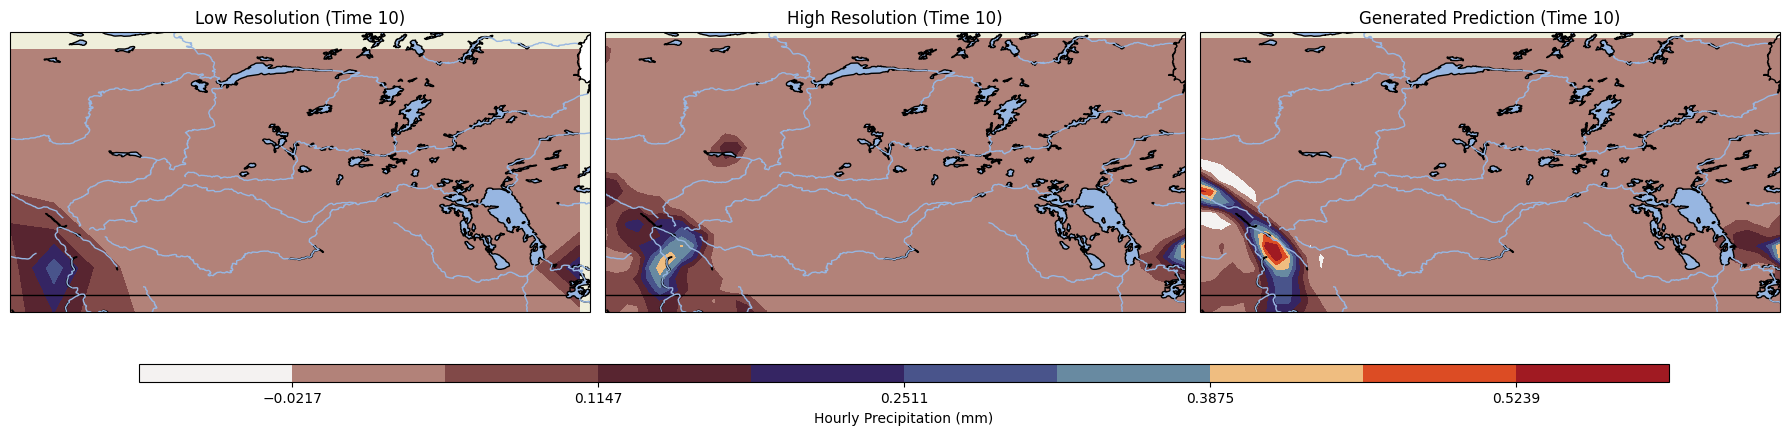

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


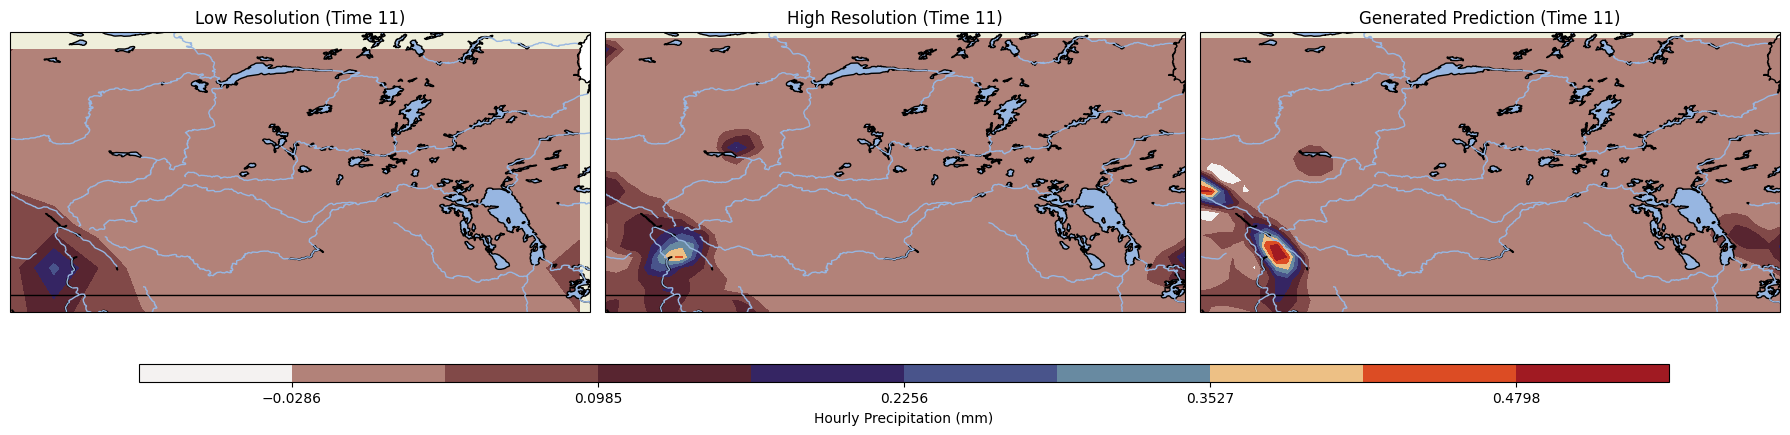

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


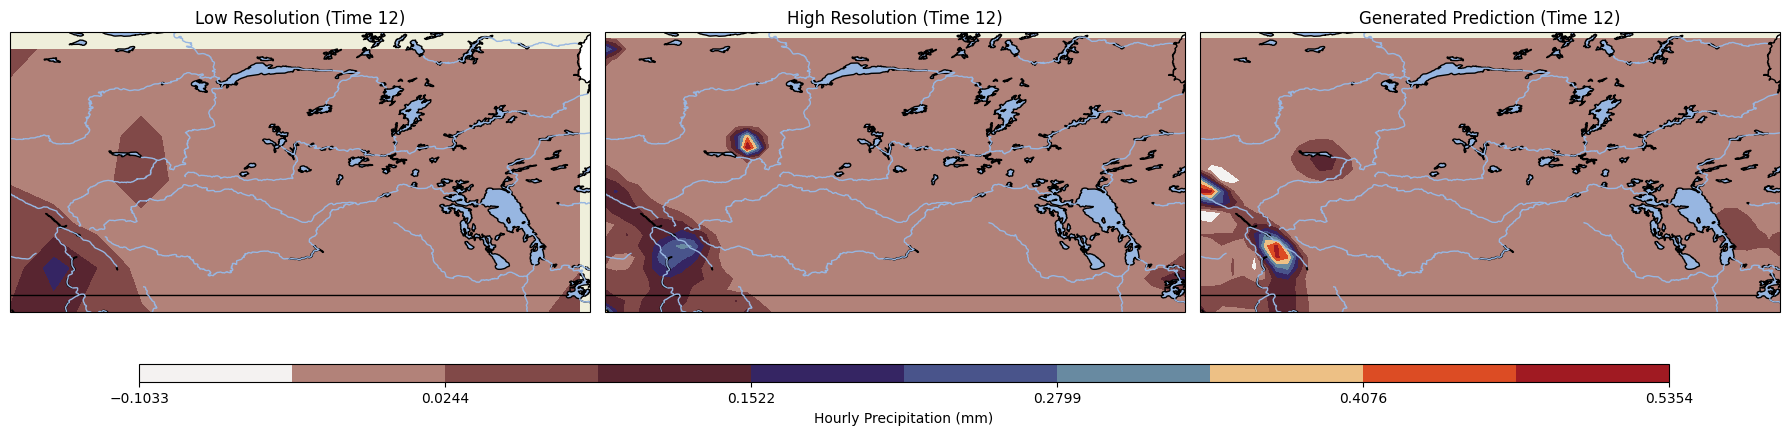

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


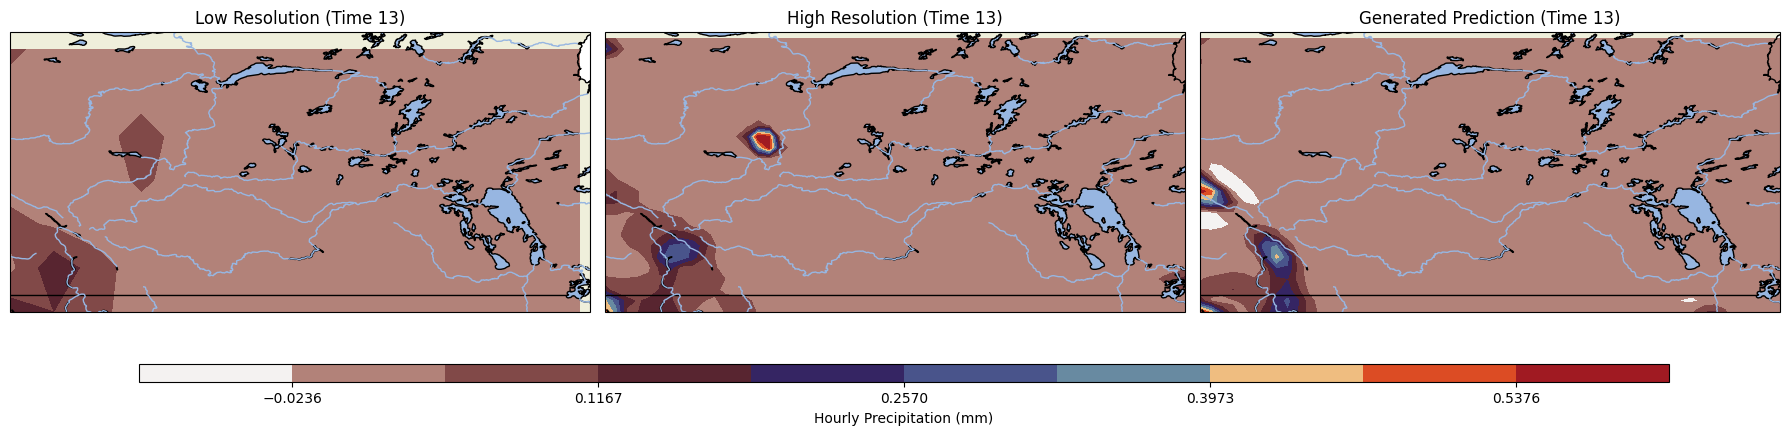

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


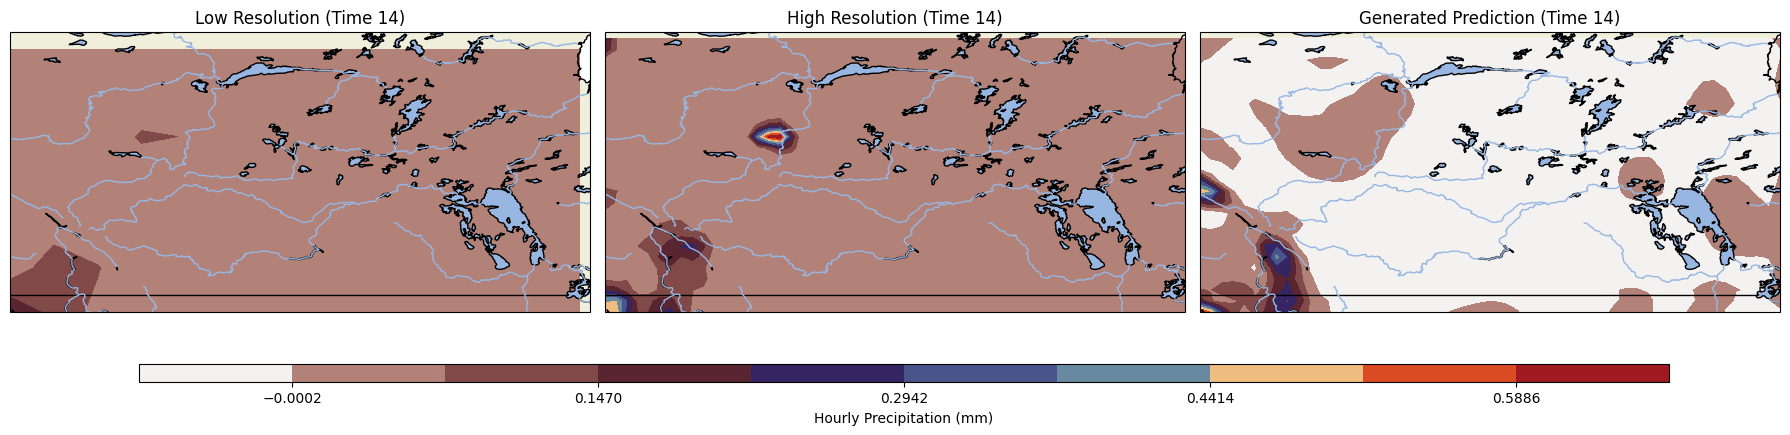

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


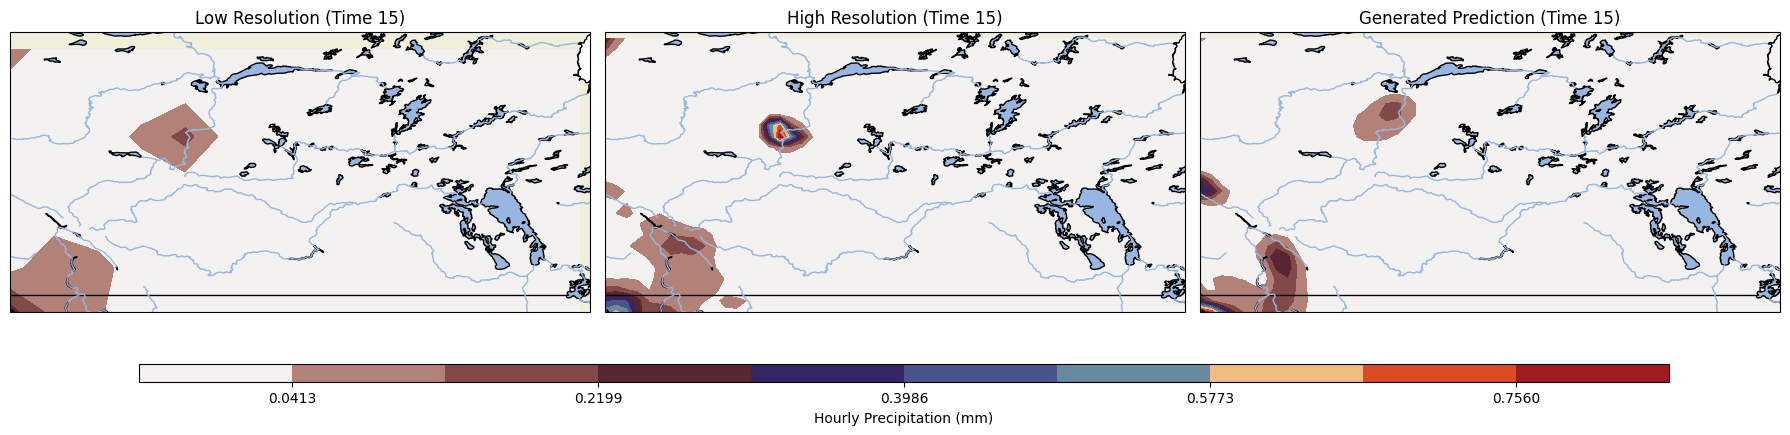

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


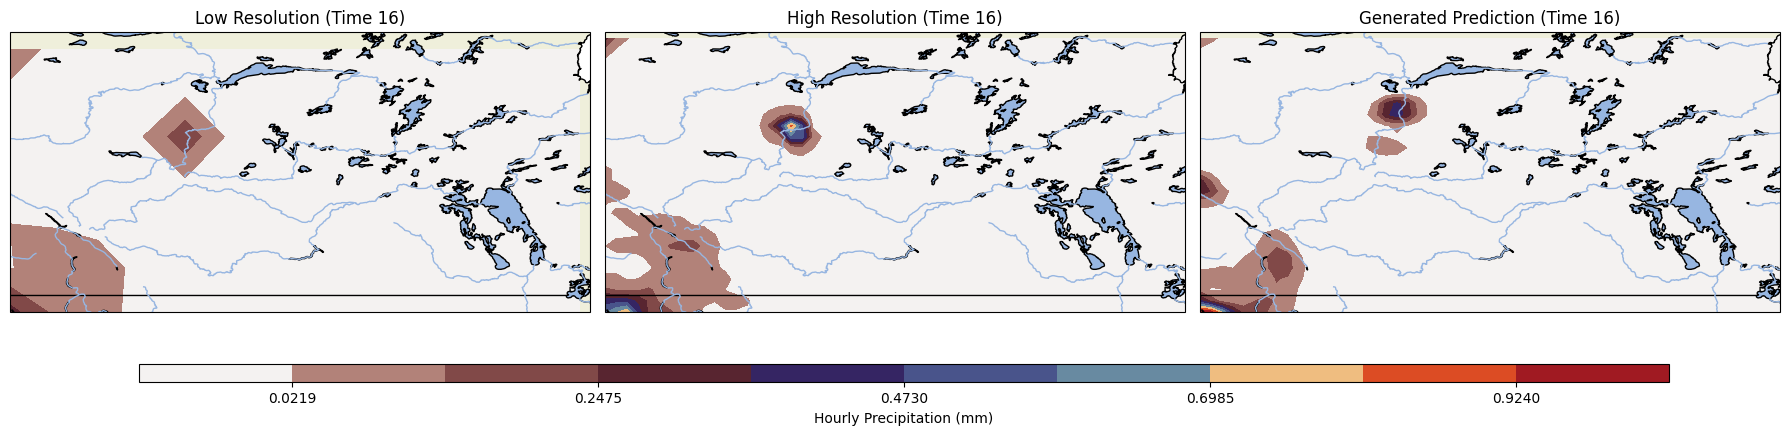

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


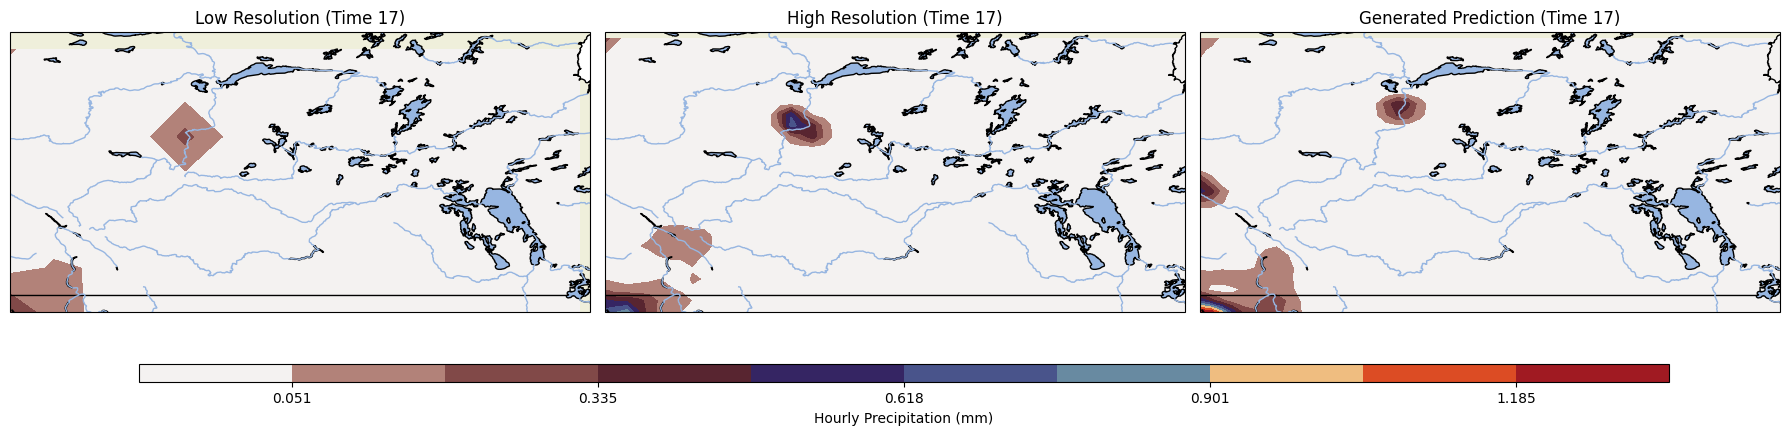

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


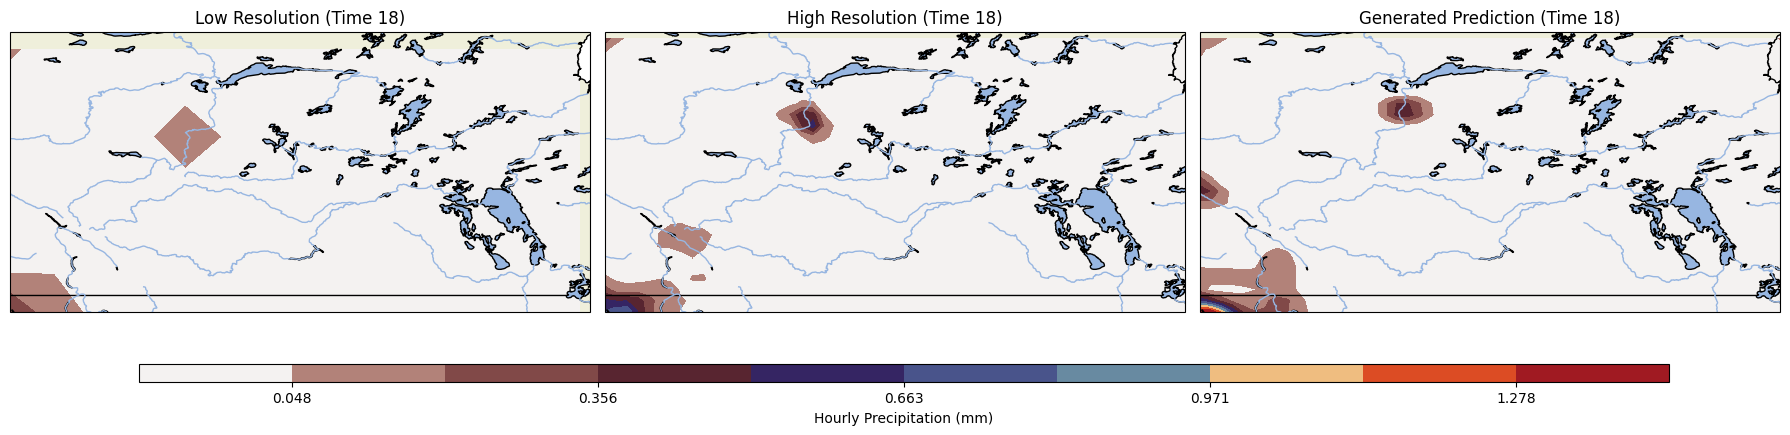

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


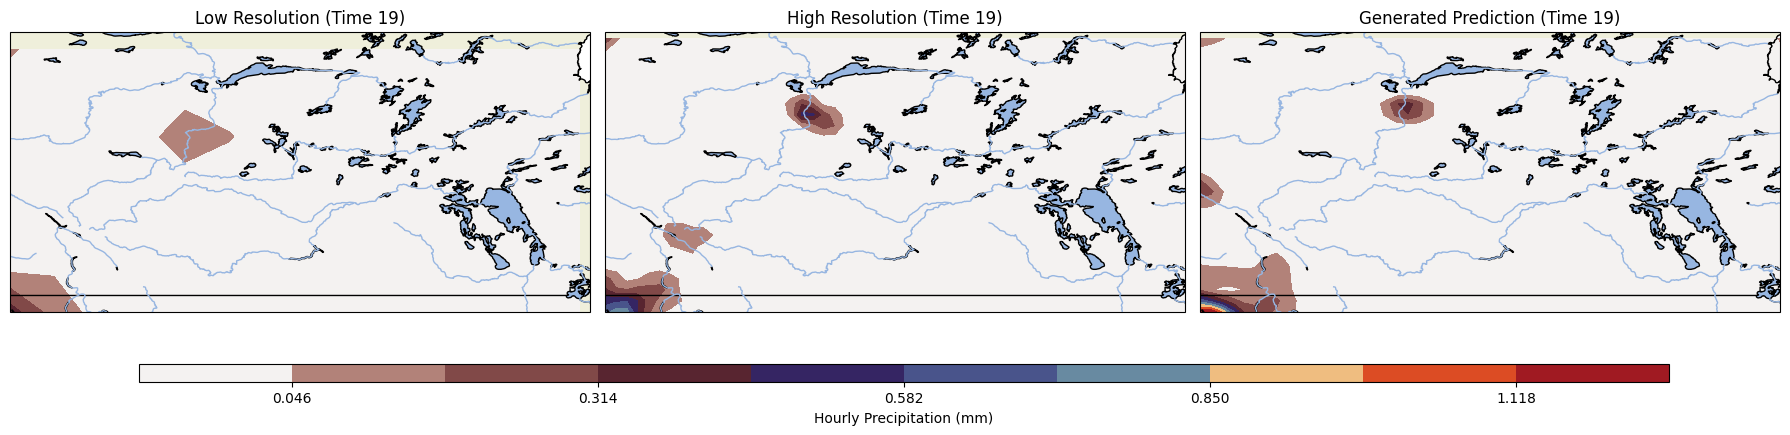

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


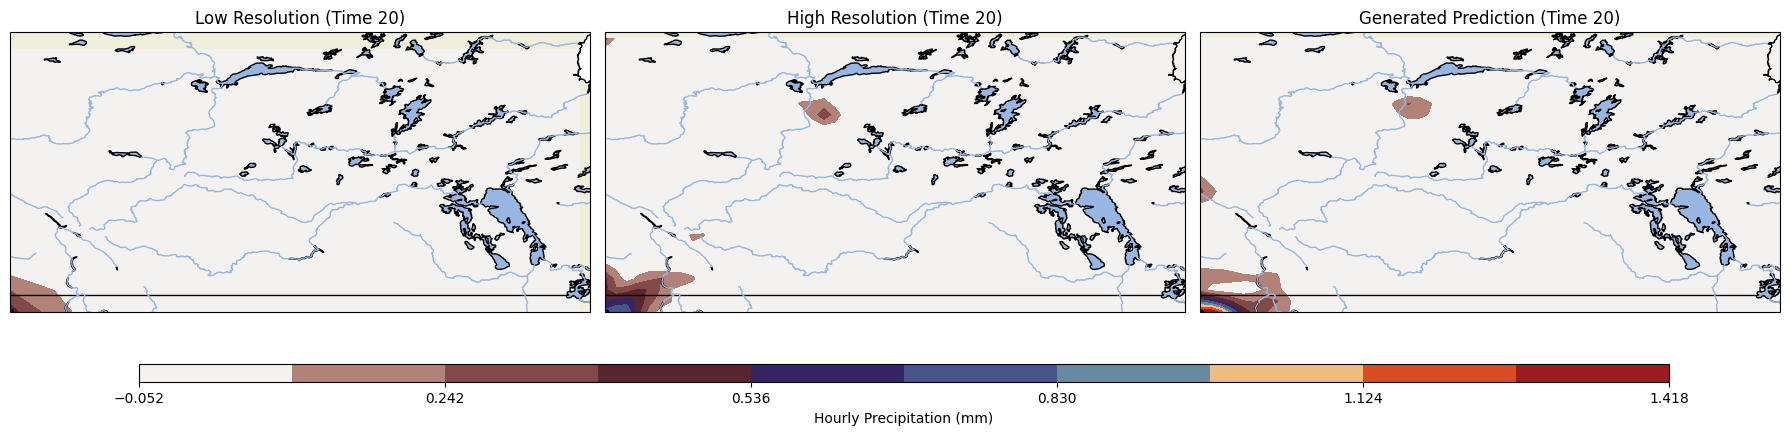

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


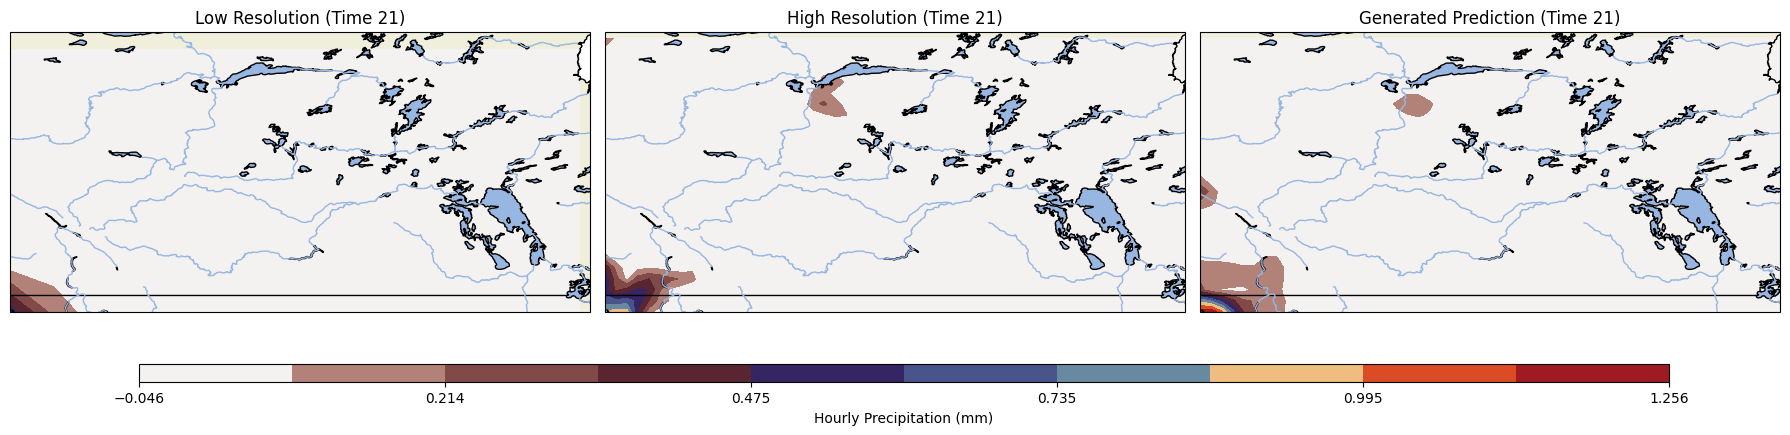

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


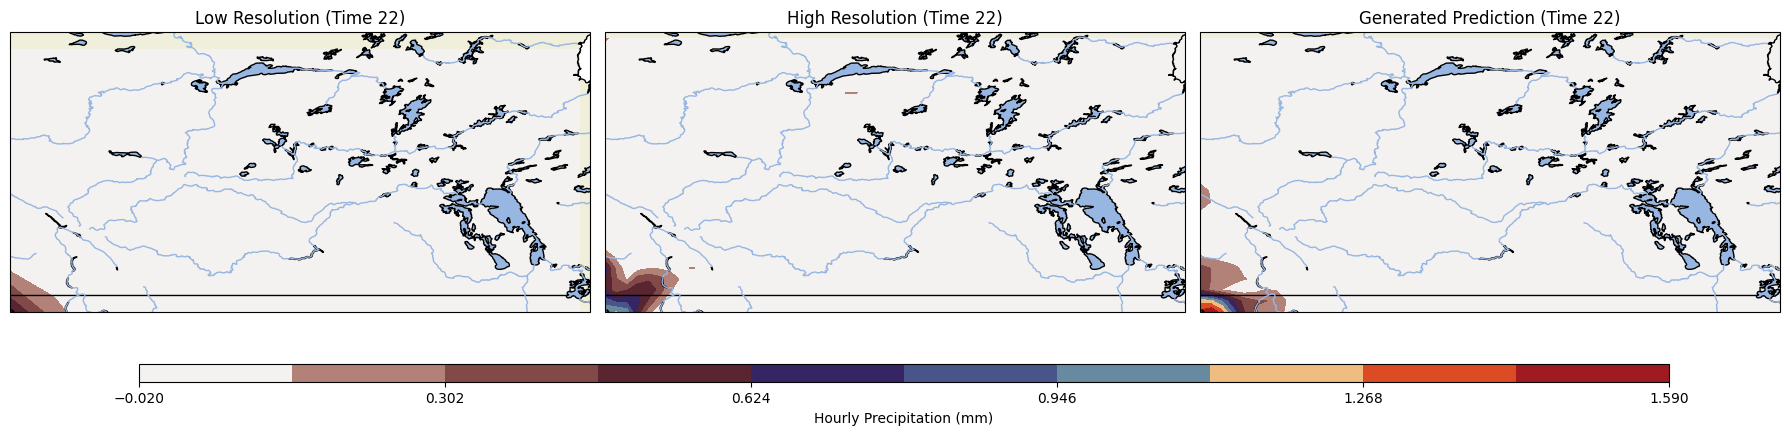

C:\Users\hebam\AppData\Local\Temp\ipykernel_2748\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


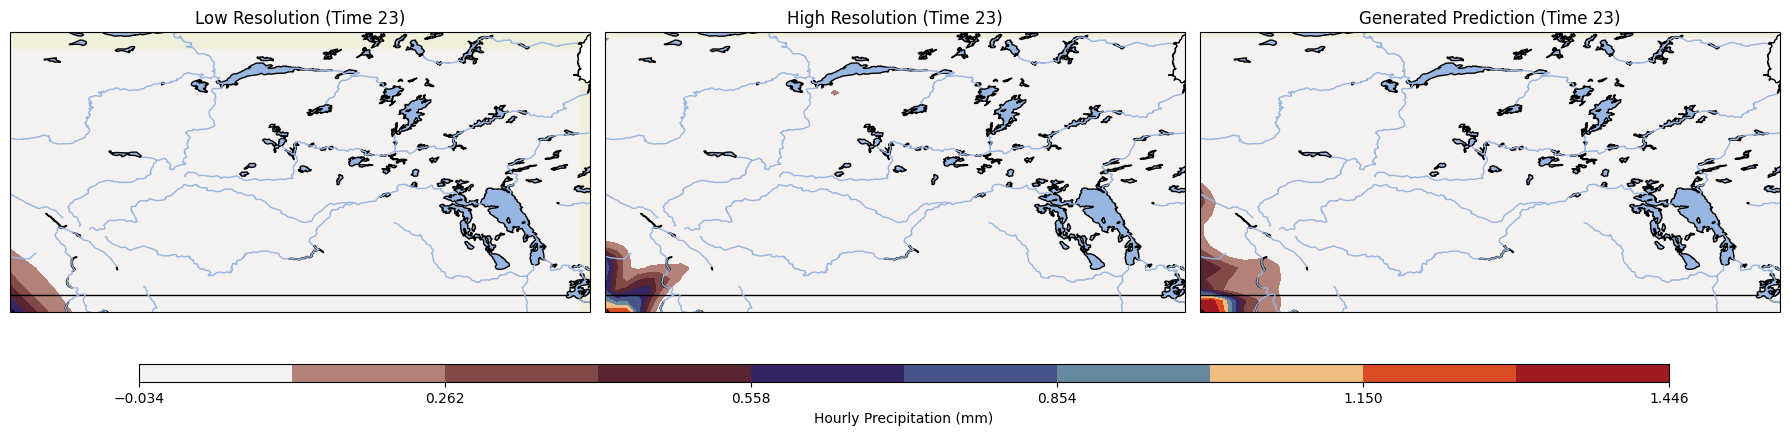

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Number of random samples to plot
num_random_samples = 1

# Generate 10 random sample indices
random_samples = np.random.choice(Xtest.shape[0], num_random_samples, replace=False)

for sample_idx in random_samples:
    print(f"Plotting sample index: {sample_idx}")
    
    # Loop over all time steps
    for time_index in range(Xtest.shape[1]):  # Assuming 24 time steps
        # Extract data for the selected sample and time step
        low_res = Xtest[sample_idx, time_index, :, :, 0]
        generated = test_predictions[sample_idx, time_index, :, :, 0]
        high_res = Ytest[sample_idx, time_index, :, :, 0]

        # Determine the global min and max for consistent color scaling
        vmin = min(low_res.min(), generated.min(), high_res.min())
        vmax = max(low_res.max(), generated.max(), high_res.max())
        levels = np.linspace(vmin, vmax, 11)

        # Latitude and longitude setup based on the high-resolution shape
        num_latitudes = high_res.shape[0]
        num_longitudes = high_res.shape[1]

        lats = np.linspace(48.25, 48.25 + (num_latitudes - 1) * 0.5, num_latitudes)
        lons = np.linspace(-120.75, -120.75 + (num_longitudes - 1) * 0.5, num_longitudes)

        lon_grid, lat_grid = np.meshgrid(lons, lats)

        # Plotting
        fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        extent = [lons.min(), lons.max(), lats.min(), lats.max()]

        # Plot low-resolution input
        axs[0].set_extent(extent)
        axs[0].add_feature(cfeature.LAND)
        axs[0].add_feature(cfeature.COASTLINE)
        axs[0].add_feature(cfeature.BORDERS)
        axs[0].add_feature(cfeature.LAKES, edgecolor='black')
        axs[0].add_feature(cfeature.RIVERS)
        im0 = axs[0].contourf(lon_grid[::4, ::4], lat_grid[::4, ::4], low_res, levels=levels, cmap=custom_cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        axs[0].set_title(f'Low Resolution (Time {time_index})')

        # Plot high-resolution ground truth
        axs[1].set_extent(extent)
        axs[1].add_feature(cfeature.LAND)
        axs[1].add_feature(cfeature.COASTLINE)
        axs[1].add_feature(cfeature.BORDERS)
        axs[1].add_feature(cfeature.LAKES, edgecolor='black')
        axs[1].add_feature(cfeature.RIVERS)
        im1 = axs[1].contourf(lon_grid, lat_grid, high_res, levels=levels, cmap=custom_cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        axs[1].set_title(f'High Resolution (Time {time_index})')

        # Plot generated high-resolution prediction
        axs[2].set_extent(extent)
        axs[2].add_feature(cfeature.LAND)
        axs[2].add_feature(cfeature.COASTLINE)
        axs[2].add_feature(cfeature.BORDERS)
        axs[2].add_feature(cfeature.LAKES, edgecolor='black')
        axs[2].add_feature(cfeature.RIVERS)
        im2 = axs[2].contourf(lon_grid, lat_grid, generated, levels=levels, cmap=custom_cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        axs[2].set_title(f'Generated Prediction (Time {time_index})')

        # Add a shared colorbar
        cbar_ax = fig.add_axes([0.08, 0.15, 0.85, 0.03])  # [left, bottom, width, height]
        cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Hourly Precipitation (mm)')

        plt.tight_layout()
        plt.show()


In [14]:
#vmax = max(Xtest[:, 0:23, :, :, 0].max(), test_predictions[:, 0:23, :, :, 0].max(), Ytest[:, 0:23, :, :, 0].max())
vmax = Ytest[:, 0:23, :, :, 0].max()
print(vmax)


38.222786


In [22]:
#Global max and min for the testing set
vmin = 0.01
vmax = max(Xtest[0:9, 0:23, :, :, 0].max(), test_predictions[0:9, 0:23, :, :, 0].max(), Ytest[0:9, 0:23, :, :, 0].max())
print(vmin)
print(vmax)

from matplotlib.colors import LogNorm
norm = LogNorm(vmin=vmin, vmax=vmax)

0.01
10.654064


In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
from matplotlib.ticker import FuncFormatter, FixedLocator

# Create a directory to save the plots
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Define the latitude and longitude limits
specified_lat_min, specified_lat_max = 48, 60
specified_lon_min, specified_lon_max = -121, -95

# Latitude and longitude setup for high-resolution data
num_latitudes_high = Ytest.shape[2]
num_longitudes_high = Ytest.shape[3]
lats_high = np.linspace(48.25, 48.25 + (num_latitudes_high - 1) * 0.5, num_latitudes_high)
lons_high = np.linspace(-120.75, -120.75 + (num_longitudes_high - 1) * 0.5, num_longitudes_high)

# Edges for high-resolution data
lat_edges_high = np.linspace(lats_high.min() - 0.25, lats_high.max() + 0.25, len(lats_high) + 1)
lon_edges_high = np.linspace(lons_high.min() - 0.25, lons_high.max() + 0.25, len(lons_high) + 1)

# Latitude and longitude setup for low-resolution data
num_latitudes_low = Xtest.shape[2]
num_longitudes_low = Xtest.shape[3]
lats_low = np.linspace(48.25, 48.25 + (num_latitudes_low - 1) * 2, num_latitudes_low)
lons_low = np.linspace(-120.75, -120.75 + (num_longitudes_low - 1) * 2, num_longitudes_low)

# Edges for low-resolution data
lat_edges_low = np.linspace(lats_low.min() - 1, lats_low.max() + 1, len(lats_low) + 1)
lon_edges_low = np.linspace(lons_low.min() - 1, lons_low.max() + 1, len(lons_low) + 1)

# Process and save plots for the first 30 samples
for sample_idx in range(11):
    print(f"Processing sample index: {sample_idx}")

    for time_index in range(Ytest.shape[1]):  # Assuming 24 time steps
        # Extract data for the selected sample and time step
        low_res = Xtest[sample_idx, time_index, :, :, 0] 
        generated = test_predictions[sample_idx, time_index, :, :, 0]
        high_res = Ytest[sample_idx, time_index, :, :, 0]

        # Determine the global min and max for consistent color scaling
        #vmin = min(low_res.min(), generated.min(), high_res.min())
        #vmax = max(low_res.max(), generated.max(), high_res.max())
        levels = np.linspace(vmin, vmax, 11)

        # Plotting
        fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        extent = [specified_lon_min, specified_lon_max, specified_lat_min, specified_lat_max]

        # Plot low-resolution input (native resolution)
        im0 = axs[0].pcolormesh(lon_edges_low, lat_edges_low, low_res, transform=ccrs.PlateCarree(),
                                cmap=custom_cmap, shading='auto', norm=norm)
        axs[0].set_title(f"Low Resolution (Time {time_index})")
        axs[0].coastlines()
        axs[0].add_feature(cfeature.BORDERS, linestyle=':')
        axs[0].set_extent(extent, crs=ccrs.PlateCarree())
        axs[0].set_xticks(np.linspace(specified_lon_min, specified_lon_max, 5), crs=ccrs.PlateCarree())
        axs[0].set_yticks(np.linspace(specified_lat_min, specified_lat_max, 5), crs=ccrs.PlateCarree())
        axs[0].set_xlabel("Longitude")
        axs[0].set_ylabel("Latitude")

        # Plot high-resolution ground truth
        im1 = axs[1].pcolormesh(lon_edges_high, lat_edges_high, high_res, transform=ccrs.PlateCarree(),
                                cmap=custom_cmap, shading='auto', norm=norm)
        axs[1].set_title(f"High Resolution (Time {time_index})")
        axs[1].coastlines()
        axs[1].add_feature(cfeature.BORDERS, linestyle=':')
        axs[1].set_extent(extent, crs=ccrs.PlateCarree())
        axs[1].set_xticks(np.linspace(specified_lon_min, specified_lon_max, 5), crs=ccrs.PlateCarree())
        axs[1].set_yticks(np.linspace(specified_lat_min, specified_lat_max, 5), crs=ccrs.PlateCarree())
        axs[1].set_xlabel("Longitude")
        axs[1].set_ylabel("Latitude")

        # Plot generated high-resolution prediction
        im2 = axs[2].pcolormesh(lon_edges_high, lat_edges_high, generated, transform=ccrs.PlateCarree(),
                                cmap=custom_cmap, shading='auto', norm=norm)
        axs[2].set_title(f"Generated Prediction (Time {time_index})")
        axs[2].coastlines()
        axs[2].add_feature(cfeature.BORDERS, linestyle=':')
        axs[2].set_extent(extent, crs=ccrs.PlateCarree())
        axs[2].set_xticks(np.linspace(specified_lon_min, specified_lon_max, 5), crs=ccrs.PlateCarree())
        axs[2].set_yticks(np.linspace(specified_lat_min, specified_lat_max, 5), crs=ccrs.PlateCarree())
        axs[2].set_xlabel("Longitude")
        axs[2].set_ylabel("Latitude")

        # Add a common colorbar below the plots
        cbar_width = 0.6  # Adjust this value to control the width of the colorbar
        cbar_left = (1 - cbar_width) / 2  # Center the colorbar

        cbar_ax = fig.add_axes([cbar_left, 0.15, cbar_width, 0.02])  # Adjust the width and center it
        cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
        cbar.set_label("Hourly Precipitation (mm)")
        
        # Customize the colorbar tick labels to show decimal numbers
        def decimal_formatter(x, pos):
            return f"{x:.2f}"  # Format ticks as decimal with two decimal places

        # Apply the formatter
        formatter = FuncFormatter(decimal_formatter)
        cbar.formatter = formatter

        # Optionally, set fixed tick locations (e.g., specific decimals)
        #ticks = np.logspace(vmin, vmax, num=6)  # Adjust `num` for more ticks
        #cbar.set_ticks(ticks)

        cbar.update_ticks()  # Update the colorbar with new tick formatting
        # Save the plot to a file
        output_file = os.path.join(output_dir, f"sample_{sample_idx}_time_{time_index}.png")
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close(fig)

    print(f"Sample {sample_idx} processed and saved.")


Processing sample index: 0
Sample 0 processed and saved.
Processing sample index: 1
Sample 1 processed and saved.
Processing sample index: 2
Sample 2 processed and saved.
Processing sample index: 3
Sample 3 processed and saved.
Processing sample index: 4
Sample 4 processed and saved.
Processing sample index: 5
Sample 5 processed and saved.
Processing sample index: 6
Sample 6 processed and saved.
Processing sample index: 7
Sample 7 processed and saved.
Processing sample index: 8
Sample 8 processed and saved.
Processing sample index: 9
Sample 9 processed and saved.
Processing sample index: 10
Sample 10 processed and saved.
